In [110]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(GenomicRanges))
library(InteractionSet)
library(ggplot2)
library(ggridges)
library(pheatmap)
library(RColorBrewer)

library(repr)
library(qvalue)
library(Seurat)
library(mclust)

source("/projects/ps-renlab2/y2xie//scripts/basics.R")
source("/projects/ps-renlab2/y2xie//scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie//scripts/DPT/BICAN_help.R")

In [4]:
suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library(org.Hs.eg.db)) 

In [5]:
### Add brain region color
cols <- read.csv("../../ref/yel_Science2023_supp/brain_dissection_anno.xls", sep = "\t")
col1 <- cols %>%  dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.color) %>% unlist
names(col1) <- cols %>%  dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.name) %>% unlist

col2 <- cols %>%  dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region.color) %>% unlist
names(col2) <- cols %>%  dplyr::select(Brain.region, Brain.region.color) %>% distinct %>%  dplyr::select(Brain.region) %>% unlist

In [6]:
cols <- read.csv("../../ref/yel_Science2023_supp/subclass_celltype_match.csv")
tmp <- distinct(cols[,c("Cell.class", "Cell.class.color")])
ccol1 <- tmp$Cell.class.color
names(ccol1) <- gsub("GLUT", "Glut", tmp$Cell.class)

tmp <- read.csv("../04.clustering/subclass_corrected.color.csv", row.names = 1)
ccol2 <- tmp$color
names(ccol2) <- tmp$MiniAtlas

In [7]:
corder <- read.table("../04.clustering/order.subclass.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character
corder2 <- read.table("../04.clustering/order.cluster.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character

qmtx <- read.table("../Figure/FIG2_H3K27ac_stratify_by_H3K27ac_cts_nmf.txt", sep = "\t", row.names = 1, header = T, check.names = F)
norder <- colnames(qmtx)

In [8]:
rmeta <- read.csv("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", sep = '\t')
gaba <- rmeta %>% filter(class == "GABA") %>% dplyr::select(subclass_corrected) %>% unlist %>% as.character %>% unique
glut <- rmeta %>% filter(class == "Glut") %>% dplyr::select(subclass_corrected) %>% unlist %>% as.character %>% unique
nonn <- rmeta %>% filter(class == "NonN") %>% dplyr::select(subclass_corrected) %>% unlist %>% as.character %>% unique

In [259]:
pair_df2 <- read.table("../06.integration/snm3c_DPT_RNA_250601.pred_subclass_match.txt", header = T)
pair_df2$MiniAtlas %>% length
pair_df2$MiniAtlas %>% unique %>% length

[1] 35

[1] 35

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


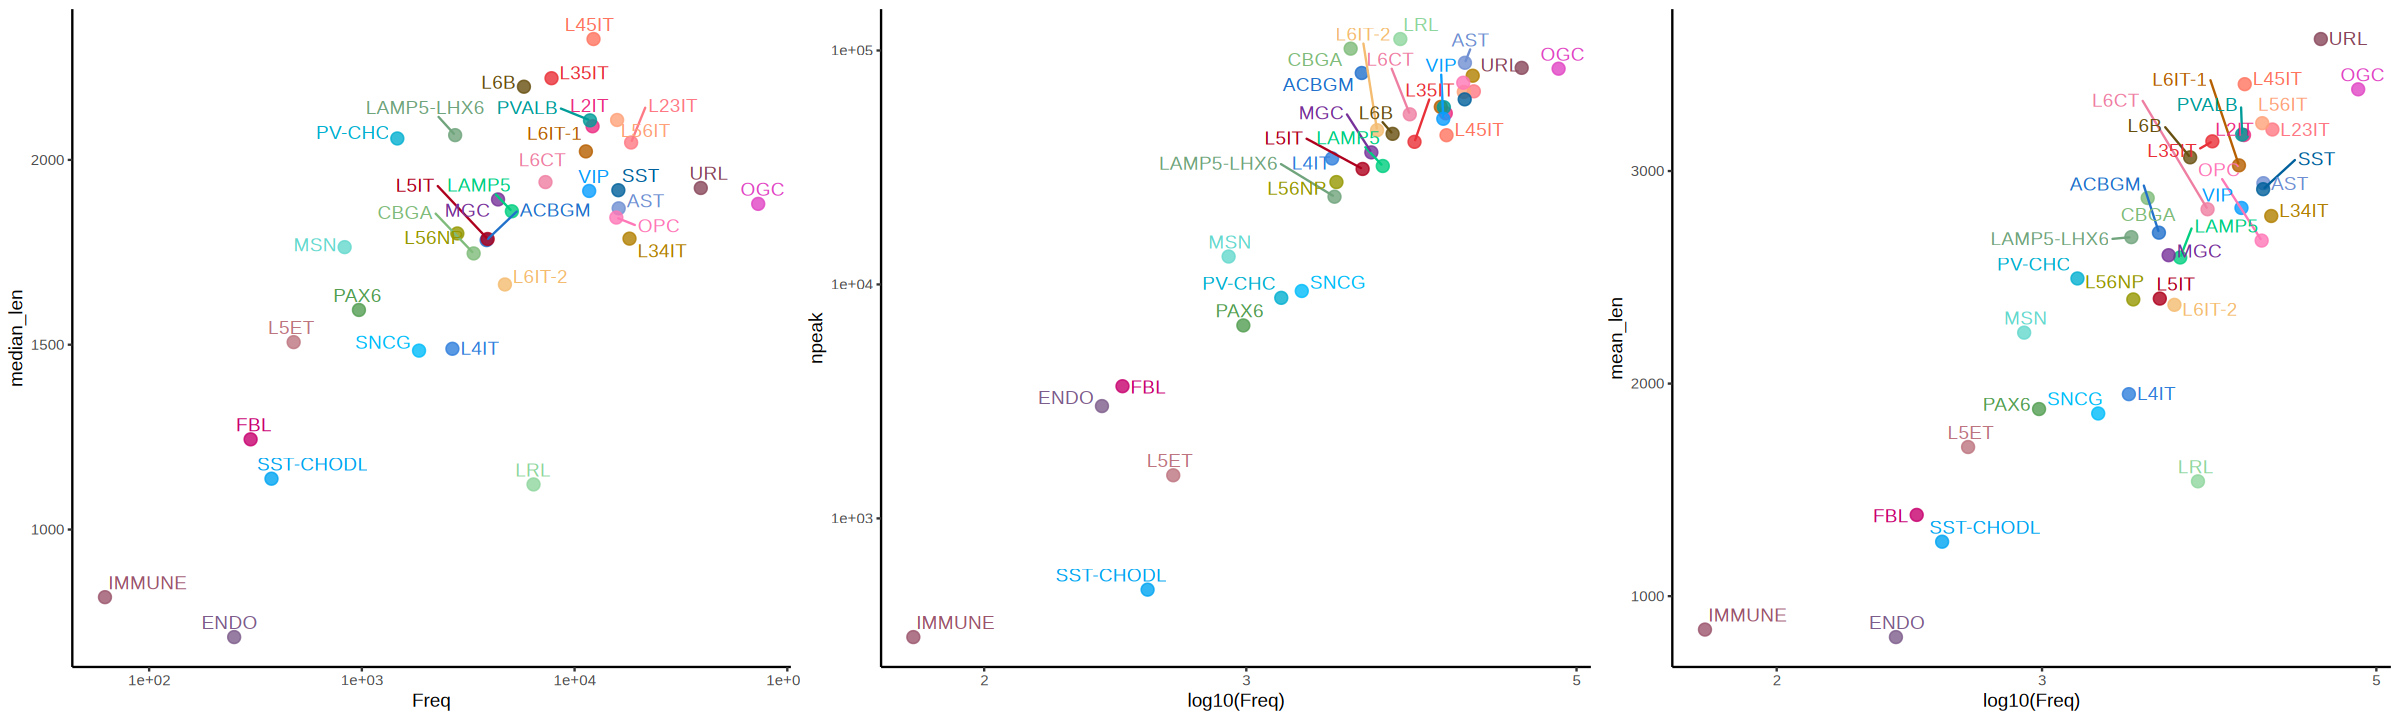

In [9]:
# flist <- list()

# for (f in list.files("250601/parseK27ac/", pattern = ".*.naivePeakList.narrowPeak.gz$")){
#     fname <- gsub(".naivePeakList.narrowPeak.gz", "", f)
#     flist[[fname]] <- read.table(paste0("250601/parseK27ac/", f)) %>%
#     dplyr::select(V1, V2, V3) %>% distinct %>%
#     mutate(len = V3 - V2)
# }

d1 <- data.frame(names(flist), unlist(lapply(flist, function(x) median(x$len)))) %>% setNames(c("subclass", "median_len")) %>%
arrange(desc(median_len))
d2 <- table(rmeta[rmeta$target == "H3K27ac",]$subclass_corrected) %>% as.data.frame
t1 <- merge(d1, d2, by.x = "subclass", by.y = "Var1") %>%
ggplot(aes(x = Freq, y = median_len, color = subclass, label = subclass)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + # scale_y_log10() + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()
         
d1 <- data.frame(names(flist), unlist(lapply(flist, function(x) length(x$len)))) %>% setNames(c("subclass", "npeak")) %>%
arrange(desc(npeak))
t2 <- merge(d1, d2, by.x = "subclass", by.y = "Var1") %>%
ggplot(aes(x = log10(Freq), y = npeak, color = subclass, label = subclass)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + scale_y_log10() + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()

d1 <- data.frame(names(flist), unlist(lapply(flist, function(x) mean(x$len)))) %>% setNames(c("subclass", "mean_len")) %>%
arrange(desc(mean_len))
t3 <- merge(d1, d2, by.x = "subclass", by.y = "Var1") %>%
ggplot(aes(x = log10(Freq), y = mean_len, color = subclass, label = subclass)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()

options(repr.plot.width = 20, repr.plot.height = 6)
cowplot::plot_grid(t1, t2, t3, ncol = 3)
### more cell longer peaks, more cell more peaks, more cell higher coverage....

In [60]:
### Try doing bedtools merge across all the peaks to create a consensus peaks et

In [10]:
badcelltype <- c("IMMUNE", "ENDO", "FBL", "SST-CHODL")

In [14]:
for (i in 1:nrow(pair_df)){
    ct1 <- pair_df[i, "MiniAtlas"]
    ct2 <- pair_df[i, "YELi"]
    p1 <- read.table(paste0("250601/parseK27ac/", ct1, ".naivePeakList.narrowPeak.gz"))
    p2 <- read.table(paste0("../07.cCREs/cCREs/subclass/", ct2, ".bed"))
    prange1 <- GRanges(p1[,1], ranges = IRanges(as.integer(p1[,2]), as.integer(p1[,3])))
    prange2 <- GRanges(p2[,1], ranges = IRanges(as.integer(p2[,2]), as.integer(p2[,3])))
    findOverlaps(queryHits(prange1, prange2))
}

MiniAtlas  YELi      
1  ACBGM      ACBGM     
2  AST        AST       
3  ENDO       EC        
4  FBL        ASCT      
5  IMMUNE     SMC       
6  MGC        MGC       
7  OGC        OGC       
8  OPC        OPC       
9  CBGA       CBGA      
10 L23IT      ITL23     
11 L2IT       ITL23     
12 L34IT      ITV1C     
13 L35IT      ITL34     
14 L45IT      ITL4      
15 L4IT       ITV1C     
16 L56IT      ITL5      
17 L56NP      NP        
18 L5ET       ET        
19 L5IT       ITL45     
20 L6B        L6B       
21 L6CT       CT        
22 L6IT-1     ITL6_1    
23 L6IT-2     ITL6_2    
24 LAMP5      LAMP5     
25 LAMP5-LHX6 LAMP5_LHX6
26 LRL        NA        
27 MSN        MSN       
28 PAX6       SNCG      
29 PV-CHC     PV_ChCs   
30 PVALB      PVALB     
31 SNCG       SNCG      
32 SST        SST       
33 SST-CHODL  SST_CHODL 
34 URL        CBGRC     
35 VIP        VIP

In [158]:
### Check overlap with ccre
df_list <- list()
pair_df <- read.table("../06.integration/snATAC_DPT_RNA_250722.pred_subclass_match.simplify.txt", col.names = c("MiniAtlas", "YELi"))
for (i in 1:nrow(pair_df)){
    if (!is.na(pair_df[i, 2])){
        ccre <- read.table(paste0("../07.cCREs/cCREs/subclass/", pair_df[i, 2], ".bed"))
        ccrange <- GenomicRanges::GRanges(ccre[, 1], IRanges::IRanges(as.integer(ccre[, 2]), as.integer(ccre[, 3])))
        peak <- read.table(paste0("250601/parseK27ac/", pair_df[i, 1], ".naivePeakList.narrowPeak.gz"), header = F) %>%
        select(V1, V2, V3) %>% distinct
        prange <- GenomicRanges::GRanges(peak[, 1], IRanges::IRanges(as.integer(peak[, 2]), as.integer(peak[, 3])))
        idx <- S4Vectors::queryHits(GenomicRanges::findOverlaps(ccrange, prange)) %>% unique
        idy <- S4Vectors::subjectHits(GenomicRanges::findOverlaps(ccrange, prange)) %>% unique
        df_list[[pair_df[i, 1]]] <- c(pair_df[i, 1], nrow(ccre), nrow(peak), length(idx), length(idy))
    }
}

Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


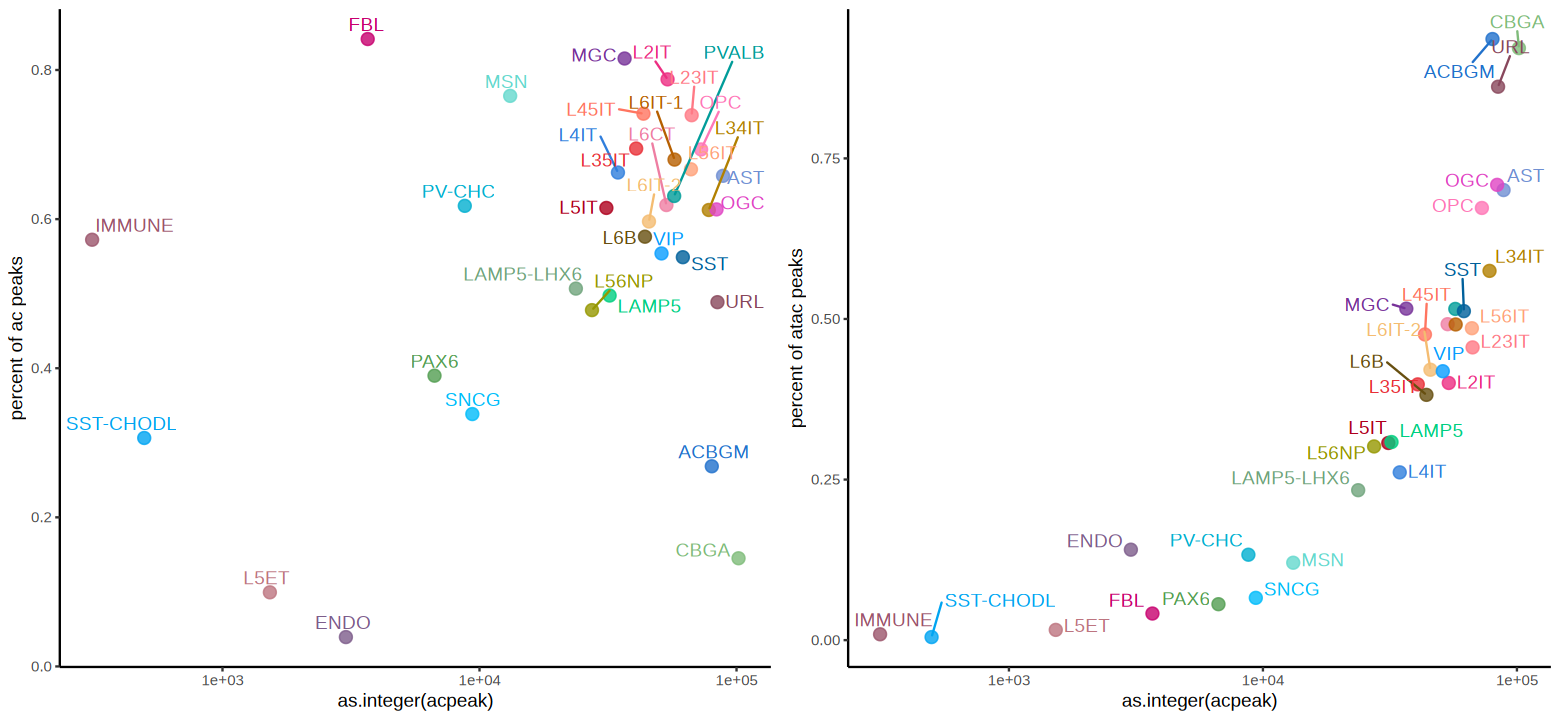

In [160]:
d1 <- data.frame(df_list) %>% t %>% as.data.frame %>%
setNames(c("subclass", "ccre", "acpeak", "ccre_ovlp", "acpeak_ovlp")) %>%
mutate(ovlp_ratio1 = as.integer(acpeak_ovlp)/as.integer(acpeak)) %>%
mutate(ovlp_ratio2 = as.integer(ccre_ovlp)/as.integer(ccre))

d2 <- table(rmeta$subclass_corrected) %>% as.data.frame

t1 <- merge(d1, d2, by.x = "subclass", by.y = "Var1") %>%
ggplot(aes(x = as.integer(acpeak), y = ovlp_ratio1, color = subclass, label = subclass)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + ylab("percent of ac peaks") + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()


t2 <- merge(d1, d2, by.x = "subclass", by.y = "Var1") %>%
ggplot(aes(x = as.integer(acpeak), y = ovlp_ratio2, color = subclass, label = subclass)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + ylab("percent of atac peaks") + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()


options(repr.plot.width = 13, repr.plot.height = 6)
cowplot::plot_grid(t1, t2, ncol = 2)

In [54]:
for (f in list.files("250601/parseK27ac/", pattern = ".*.naivePeakList.narrowPeak.gz$")){
    fname <- gsub(".naivePeakList.narrowPeak.gz", "", f)
    tmp <- read.table(paste0("250601/parseK27ac/", f)) %>%
    mutate(spm = 10^6*V9/sum(V9)) %>%
    filter(spm > 2)

    write.table(tmp, paste0("/projects/ps-renlab2/y2xie/public_html/BICAN/MiniAtlas_subclass/05.peaks_calling/H3K27ac_peaks/", fname, ".naivePeakList.spm2.narrowPeak"), sep = "\t", quote = F, row.names = F, col.names = F)
}

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behav

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behav

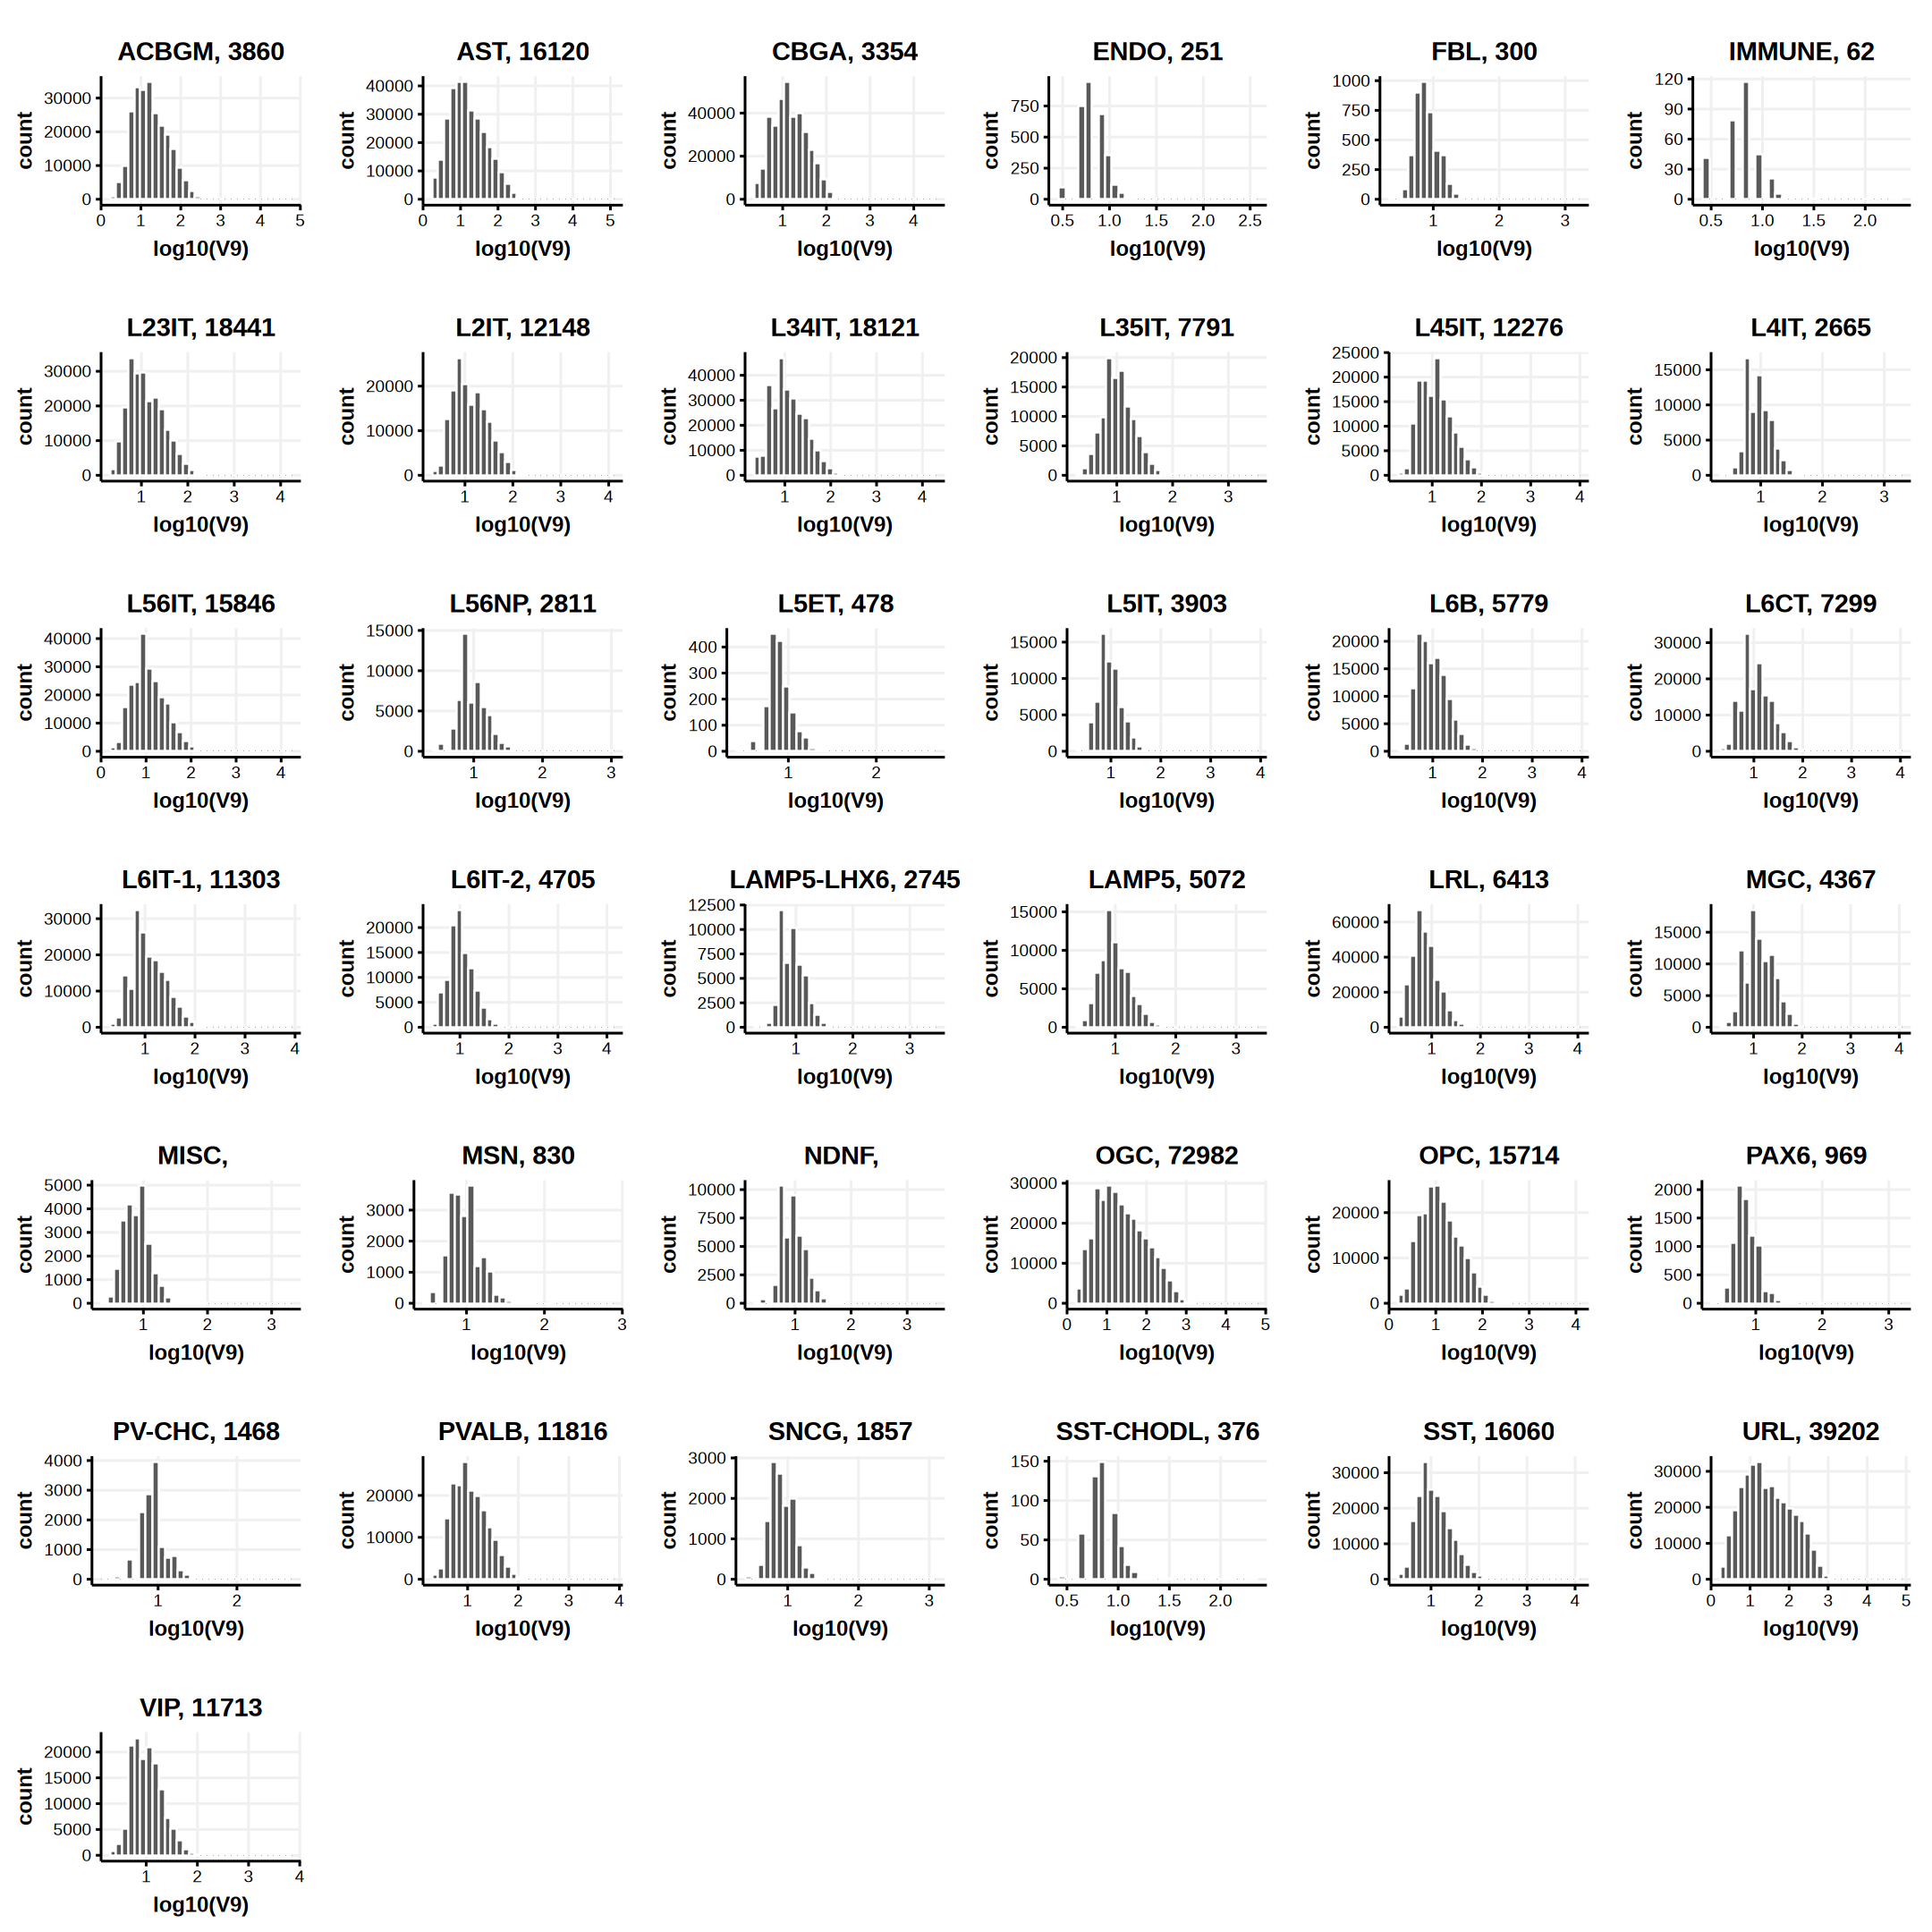

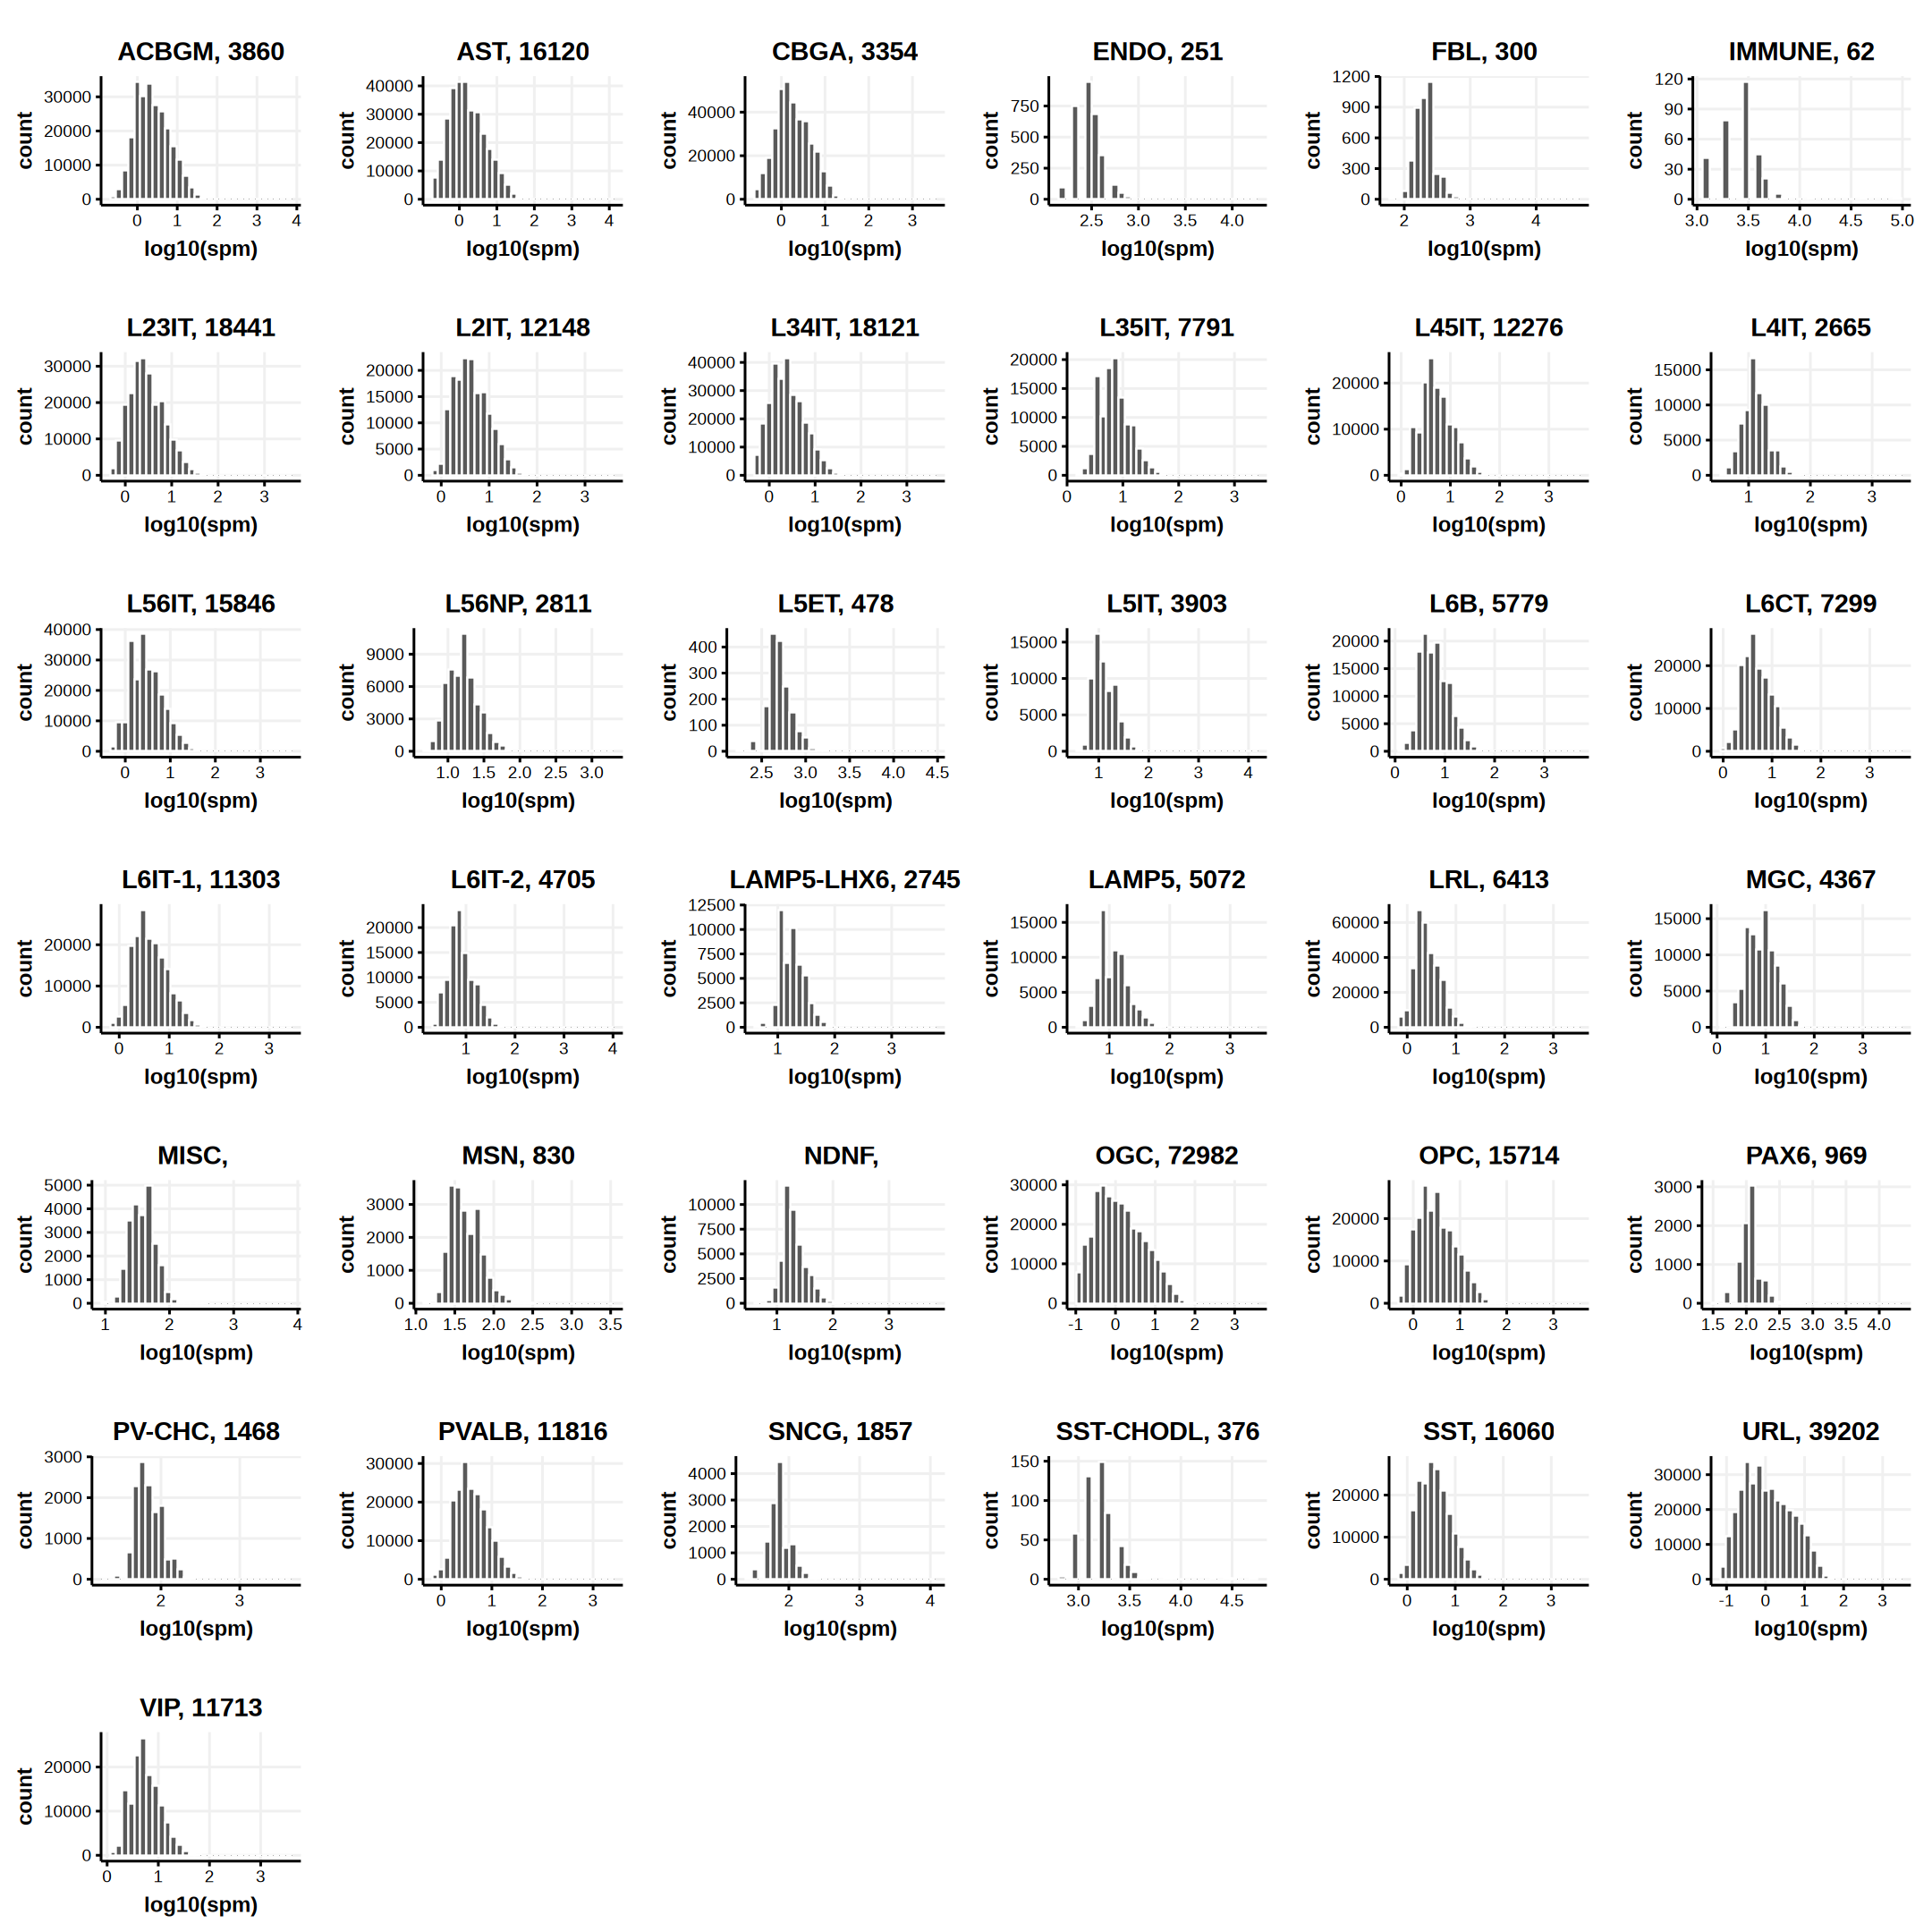

In [21]:
### Plot peak score
flist <- plist <- plist2 <- list()
for (f in list.files("250601/parseK27ac/", pattern = ".*.naivePeakList.narrowPeak.gz$")){
    fname <- gsub(".naivePeakList.narrowPeak.gz", "", f)
    flist[[fname]] <- read.table(paste0("250601/parseK27ac/", f)) %>%
    mutate(range = paste0(V1, ":", V2, "-", V3)) %>%
#     group_by(range) %>% slice_max(order_by = V9, n = 1) %>% ungroup %>%
    dplyr::select(V1, V2, V3, V9) %>% #distinct %>%
    mutate(spm = 10^6*V9/sum(V9))
    
    plist[[fname]] <- flist[[fname]] %>%
    ggplot(aes(x = log10(V9))) + 
    geom_histogram(color = "white") + 
    theme_Publication() + 
    ggtitle(paste0(fname, ", ", d2[d2$Var1 == fname, ]$Freq))
    
    plist2[[fname]] <- flist[[fname]] %>%
    ggplot(aes(x = log10(spm))) + 
    geom_histogram(color = "white") + 
    theme_Publication() + 
    ggtitle(paste0(fname, ", ", d2[d2$Var1 == fname, ]$Freq))
}

options(repr.plot.width = 18, repr.plot.height = 18)
cowplot::plot_grid(plotlist = plist, ncol = 6)
cowplot::plot_grid(plotlist = plist2, ncol = 6)

In [22]:
## Try SPM normalization
lapply(flist, nrow) %>% as.data.frame
lapply(flist, function(x) nrow(x[x$spm > 2,])) %>% as.data.frame
lapply(flist, function(x) nrow(x[x$spm > 5,])) %>% as.data.frame

ACBGM  AST    CBGA   ENDO FBL  IMMUNE L23IT  L2IT   L34IT  L35IT  ⋯ OGC   
1 242559 306678 358551 3040 4071 314    222354 160394 272634 111658 ⋯ 293221
  OPC    PAX6 PV.CHC PVALB  SNCG  SST.CHODL SST    URL    VIP   
1 201278 7949 12979  181790 12571 506       185486 329497 139211

ACBGM  AST    CBGA   ENDO FBL  IMMUNE L23IT  L2IT   L34IT  L35IT  ⋯ OGC   
1 127797 121036 154758 3040 4071 314    137197 135233 158172 111306 ⋯ 105833
  OPC    PAX6 PV.CHC PVALB  SNCG  SST.CHODL SST    URL    VIP   
1 133583 7949 12979  152203 12571 506       152528 113013 136174

ACBGM AST   CBGA  ENDO FBL  IMMUNE L23IT L2IT  L34IT L35IT ⋯ OGC   OPC   PAX6
1 58345 52728 53399 3040 4071 314    57555 63162 57587 79065 ⋯ 55353 58917 7949
  PV.CHC PVALB SNCG  SST.CHODL SST   URL   VIP  
1 12979  63272 12571 506       64017 60004 77208

In [35]:
### write example
f <- "URL"
write.table(flist[[f]], paste0("/projects//ps-renlab2/y2xie/public_html/BICAN/MiniAtlas_subclass/", f, "_H3K27ac.bed"), row.names = F, col.names = F, quote = F, sep = "\t")
write.table(flist[[f]] %>% filter(spm>2), paste0("/projects//ps-renlab2/y2xie/public_html/BICAN/MiniAtlas_subclass/", f, "_H3K27ac_spm2.bed"), row.names = F, col.names = F, quote = F, sep = "\t")
write.table(flist[[f]] %>% filter(spm>5), paste0("/projects//ps-renlab2/y2xie/public_html/BICAN/MiniAtlas_subclass/", f, "_H3K27ac_spm5.bed"), row.names = F, col.names = F, quote = F, sep = "\t")

Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 18 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


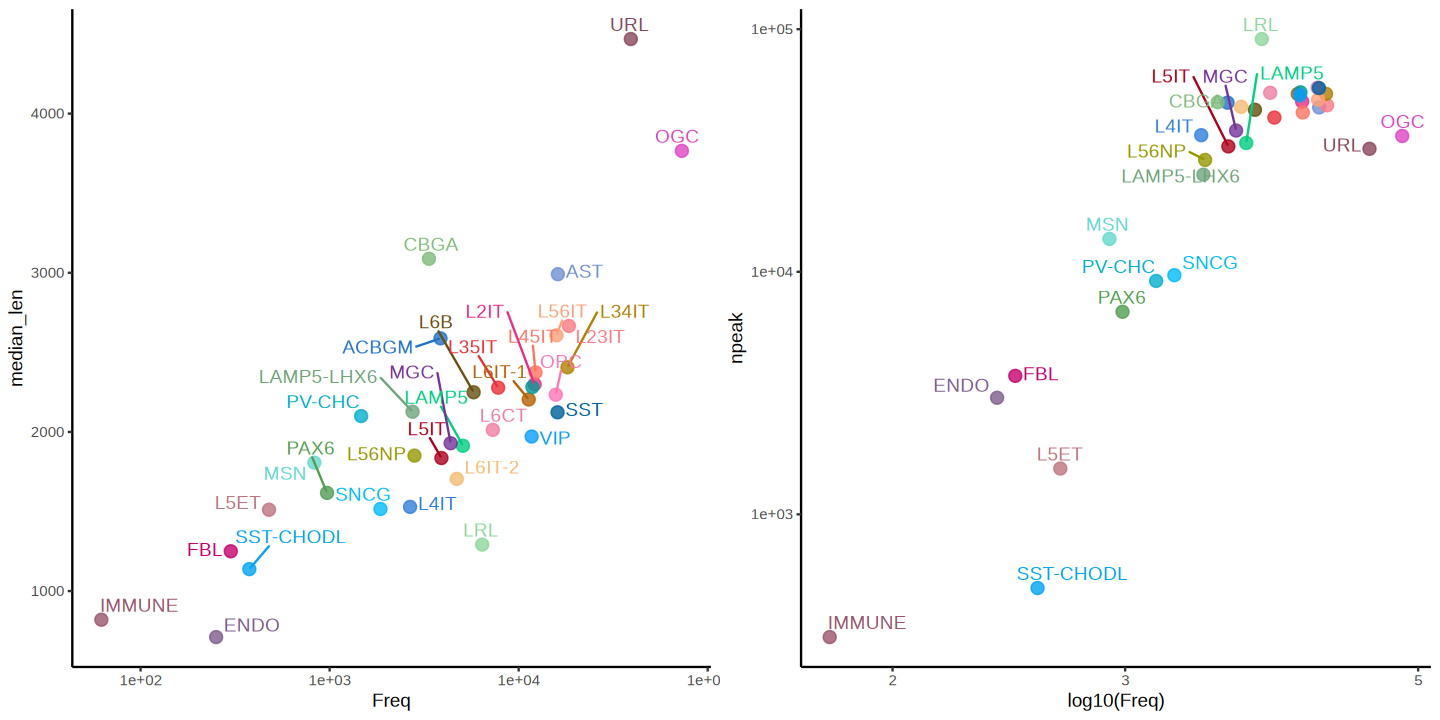

In [32]:
### SPM2 cutoff
d1 <- data.frame(names(flist), unlist(lapply(flist, function(x) x %>% filter(spm >= 2) %>% 
                                                                       group_by(V1, V2, V3) %>% 
                                                                       slice_max(order_by = V9, n = 1) %>% 
                                                                       ungroup %>% 
                                                                       dplyr:: mutate(len = V3 - V2) %>% 
                                                                       dplyr::select(len) %>% unlist %>% median))) %>% 
                                             setNames(c("subclass", "median_len")) %>%
arrange(desc(median_len))
d2 <- table(rmeta[rmeta$target == "H3K27ac",]$subclass_corrected) %>% as.data.frame
t1 <- merge(d1, d2, by.x = "subclass", by.y = "Var1") %>%
ggplot(aes(x = Freq, y = median_len, color = subclass, label = subclass)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + # scale_y_log10() + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()
         
d1 <- data.frame(names(flist), unlist(lapply(flist, function(x) x %>% filter(spm >= 2) %>% 
                                                                       group_by(V1, V2, V3) %>% 
                                                                       slice_max(order_by = V9, n = 1) %>% 
                                                                       ungroup %>% 
                                                                       dplyr:: mutate(len = V3 - V2) %>% 
                                                                       dplyr::select(len) %>% unlist %>% length))) %>% 
                                             setNames(c("subclass", "npeak")) %>%
arrange(desc(npeak))
t2 <- merge(d1, d2, by.x = "subclass", by.y = "Var1") %>%
ggplot(aes(x = log10(Freq), y = npeak, color = subclass, label = subclass)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + scale_y_log10() + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()

options(repr.plot.width = 12, repr.plot.height = 6)
cowplot::plot_grid(t1, t2, ncol = 2)

Warning message:
“ggrepel: 22 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


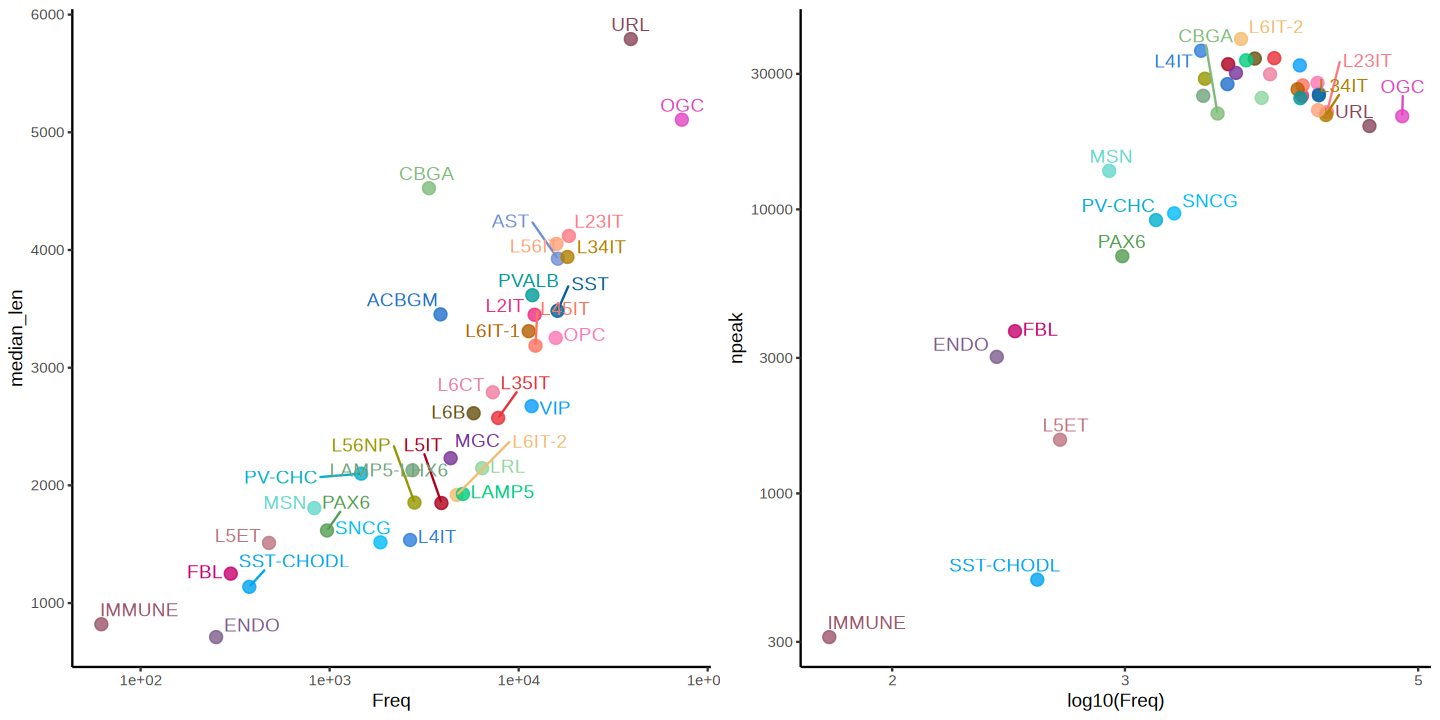

In [31]:
### SPM5 cutoff
d1 <- data.frame(names(flist), unlist(lapply(flist, function(x) x %>% filter(spm >= 5) %>% 
                                                                       group_by(V1, V2, V3) %>% 
                                                                       slice_max(order_by = V9, n = 1) %>% 
                                                                       ungroup %>% 
                                                                       dplyr:: mutate(len = V3 - V2) %>% 
                                                                       dplyr::select(len) %>% unlist %>% median))) %>% 
                                             setNames(c("subclass", "median_len")) %>%
arrange(desc(median_len))
d2 <- table(rmeta[rmeta$target == "H3K27ac",]$subclass_corrected) %>% as.data.frame
t1 <- merge(d1, d2, by.x = "subclass", by.y = "Var1") %>%
ggplot(aes(x = Freq, y = median_len, color = subclass, label = subclass)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + # scale_y_log10() + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()
         
d1 <- data.frame(names(flist), unlist(lapply(flist, function(x) x %>% filter(spm >= 5) %>% 
                                                                       group_by(V1, V2, V3) %>% 
                                                                       slice_max(order_by = V9, n = 1) %>% 
                                                                       ungroup %>% 
                                                                       dplyr:: mutate(len = V3 - V2) %>% 
                                                                       dplyr::select(len) %>% unlist %>% length))) %>% 
                                             setNames(c("subclass", "npeak")) %>%
arrange(desc(npeak))
t2 <- merge(d1, d2, by.x = "subclass", by.y = "Var1") %>%
ggplot(aes(x = log10(Freq), y = npeak, color = subclass, label = subclass)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + scale_y_log10() + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()

options(repr.plot.width = 12, repr.plot.height = 6)
cowplot::plot_grid(t1, t2, ncol = 2)

### SPM cutoff: control peaks number, but not peak length

In [97]:
corder

[1] "OGC"        "MGC"        "IMMUNE"     "ENDO"       "AST"       
 [6] "ACBGM"      "FBL"        "OPC"        "LAMP5-LHX6" "LAMP5"     
[11] "PAX6"       "SST"        "PVALB"      "PV-CHC"     "VIP"       
[16] "SNCG"       "SST-CHODL"  "MSN"        "CBGA"       "L6CT"      
[21] "L6B"        "L6IT-2"     "L2IT"       "L23IT"      "L34IT"     
[26] "L6IT-1"     "L56IT"      "L35IT"      "L5IT"       "L45IT"     
[31] "L5ET"       "L56NP"      "LRL"        "L4IT"       "URL"

In [98]:
plist <- list()
for (file in list.files("250601/MiniAtlas_subclass_H3K27ac/", pattern = ".*.bed")){
    fname <- gsub("MiniAtlas_subclass_H3K27ac.([^_]+).bed", "\\1", file)
    if (fname %in% corder){
        peak1 <- read.table(paste0("250601/MiniAtlas_subclass_H3K27ac/", file))
        peak2 <- read.table(paste0("250601/parseK27ac/", fname, ".naivePeakList.narrowPeak.gz")) %>%
        dplyr::select(V1, V2, V3) %>% distinct
        lrange1 <- GRanges(peak1[,1], ranges = IRanges(peak1[,2], peak1[,3]))
        lrange2 <- GRanges(peak2[,1], ranges = IRanges(peak2[,2], peak2[,3]))
    
        plist[[fname]] <- as.data.frame(findOverlapPairs(lrange1, lrange2)) %>%
        group_by(second.seqnames, second.start, second.end, second.width) %>%
        summarise(npeak = n_distinct(first.seqnames, first.start, first.end)) %>%
        ungroup %>%
        ggplot(aes(x = second.width, y = npeak)) + 
        geom_point() + ggtitle(fname) +
        theme_Publication()    
    }
}

`summarise()` has grouped output by 'second.seqnames', 'second.start', 'second.end'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
`summarise()` has grouped output by 'second.seqnames', 'second.start', 'second.end'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
`summarise()` has grouped output by 'second.seqnames', 'second.start', 'second.end'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
`summarise()` has grouped output by 'second.seqnames', 'second.start', 'second.end'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
`summarise()` ha

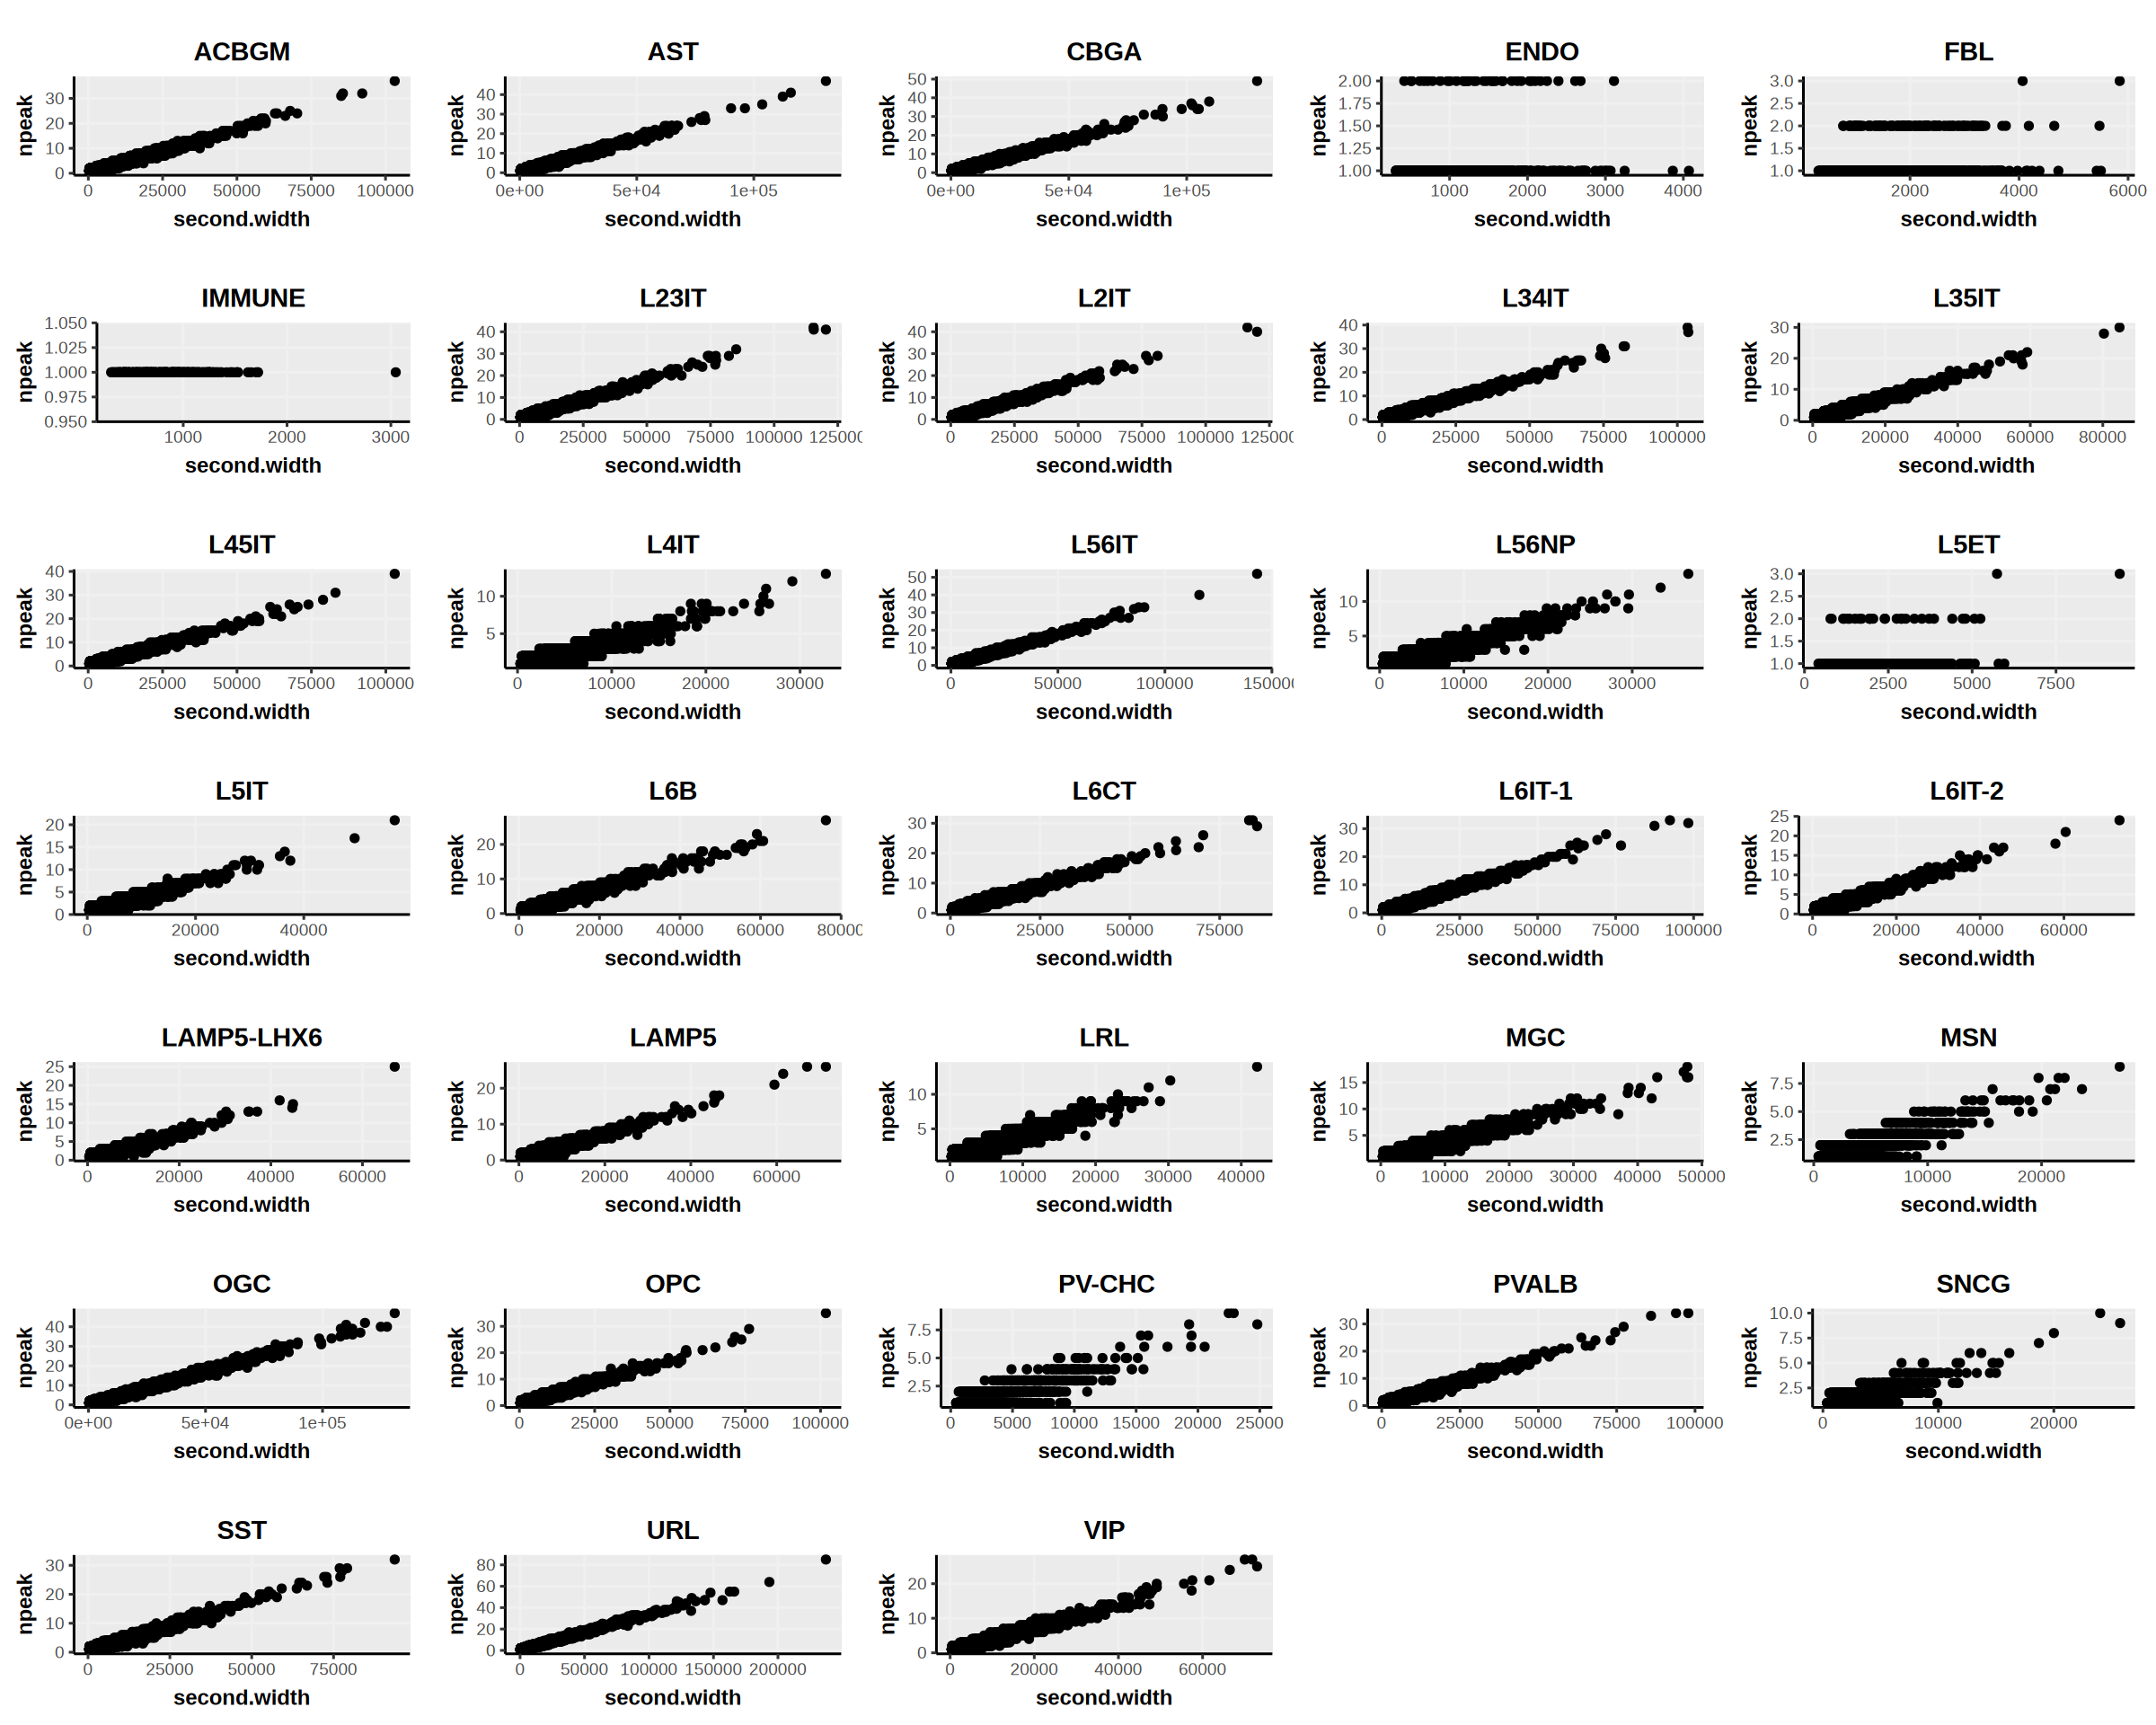

In [99]:
options(repr.plot.width = 20, repr.plot.height = 16)
cowplot::plot_grid(plotlist = plist, ncol = 5)

`summarise()` has grouped output by 'second.seqnames', 'second.start', 'second.end'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


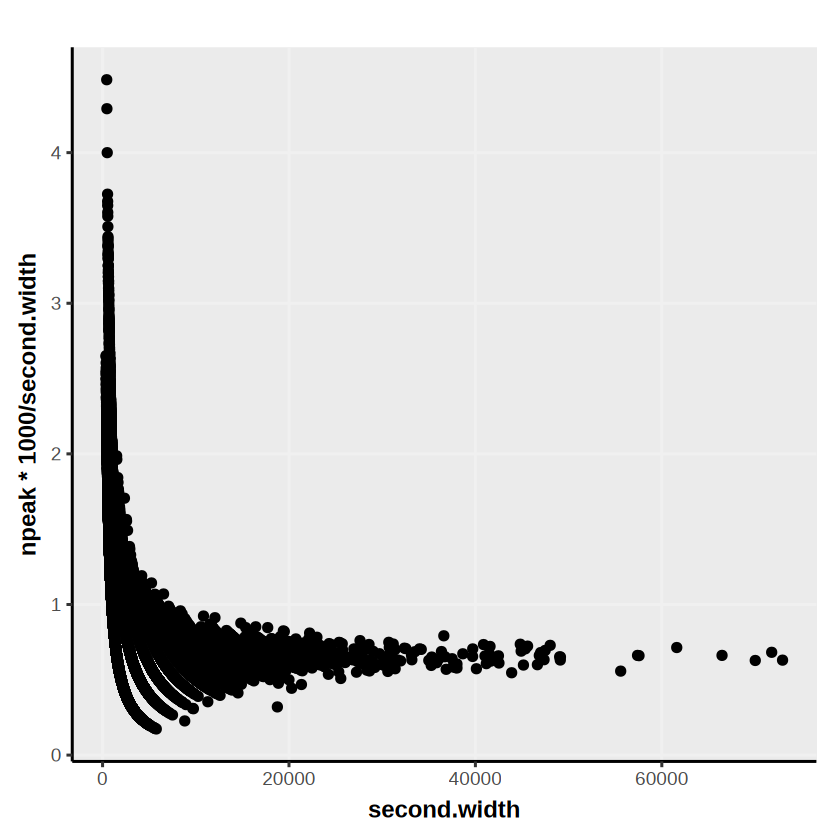

In [73]:
as.data.frame(findOverlapPairs(lrange1, lrange2)) %>%
group_by(second.seqnames, second.start, second.end, second.width) %>%
summarise(npeak = n_distinct(first.seqnames, first.start, first.end)) %>%
ungroup %>%
ggplot(aes(x = second.width, y = npeak*1000/second.width)) + 
geom_point() + 
theme_Publication()

### we can determine if a narrowpeak is differential based on the 
### number of consensus peaks overlapped called to be differential

In [100]:
tlist <- list()
i = 1
for (file in list.files("250601/MiniAtlas_subclass_H3K27ac/spm2/", pattern = "MiniAtlas_subclass_H3K27ac.*.")){
    fname <- gsub("MiniAtlas_subclass_H3K27ac.([^.]+).bed", "\\1", file)
    tmp1 <- system(paste0("wc -l < 250601/MiniAtlas_subclass_H3K27ac/", file), intern = T)
    tmp2 <- system(paste0("wc -l < 250601/MiniAtlas_subclass_H3K27ac/spm2/", file), intern = T)
    tmp3 <- system(paste0("wc -l < 250601/MiniAtlas_subclass_H3K27ac/spm5/", file), intern = T)
    tlist[[i]] <- data.frame(npeak_spm = tmp1, npeak_spm2 = tmp2, npeak_spm5 = tmp3, celltype = fname)
    i = i + 1
}

tlist <- do.call(rbind, tlist)

Warning message in system(paste0("wc -l < 250601/MiniAtlas_subclass_H3K27ac/", file), :
“running command 'wc -l < 250601/MiniAtlas_subclass_H3K27ac/MiniAtlas_subclass_H3K27ac.PAX6.bed' had status 2”


ERROR: Error in data.frame(npeak_spm = tmp1, npeak_spm2 = tmp2, npeak_spm5 = tmp3, : arguments imply differing number of rows: 0, 1


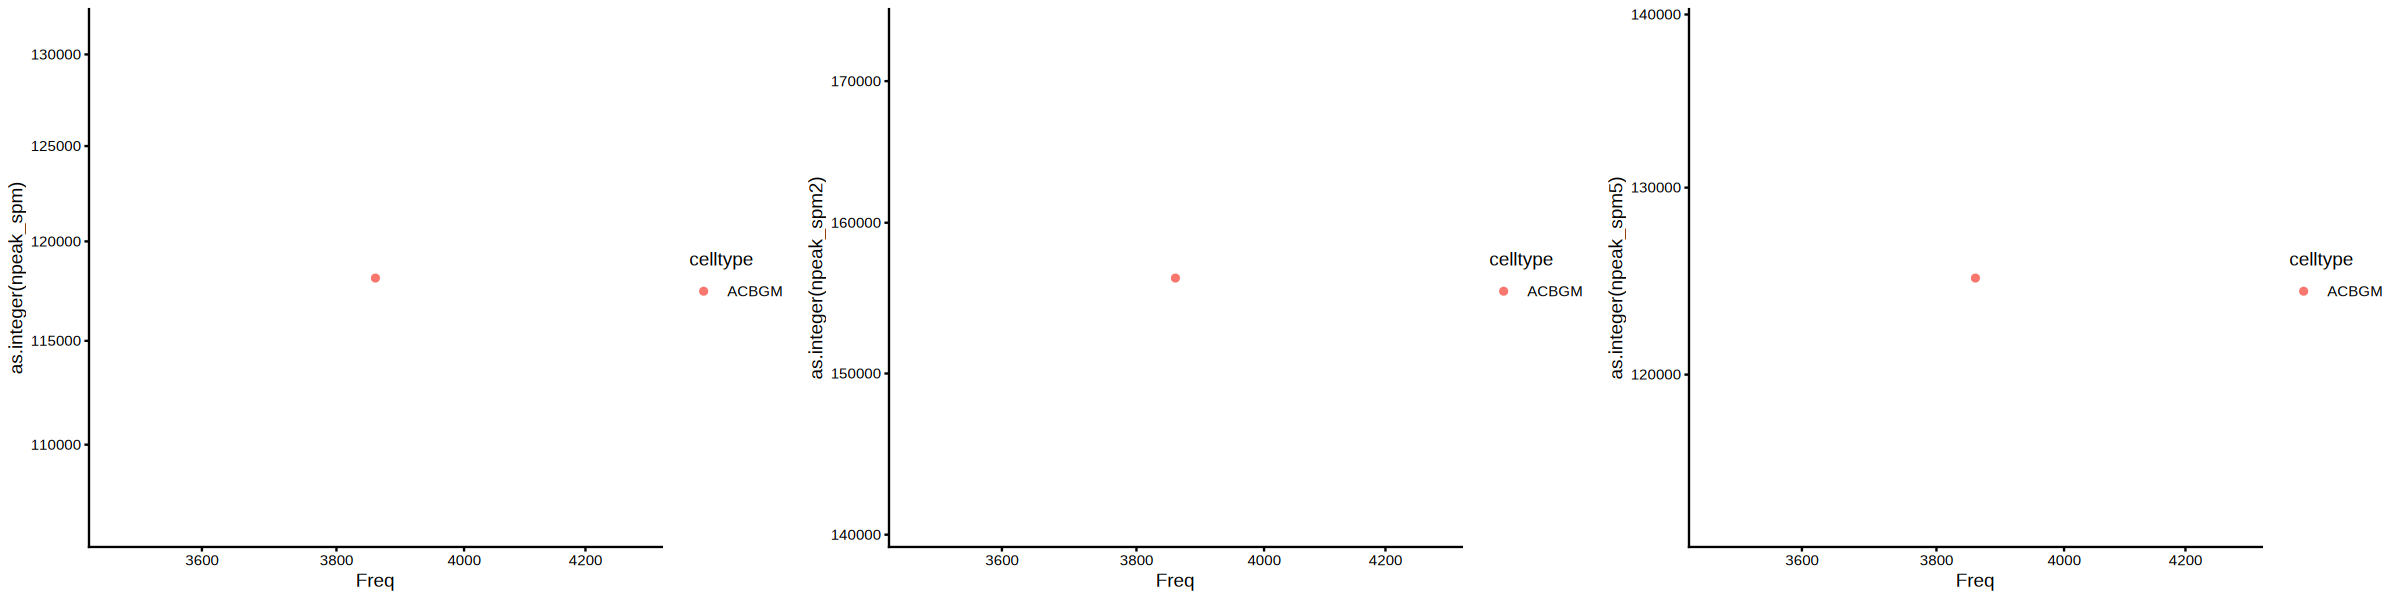

In [101]:
t1 <- merge(tlist, d2, by.x = "celltype", by.y = "Var1") %>%
ggplot(aes(x = Freq, y = as.integer(npeak_spm), color = celltype)) + 
geom_point() + 
# ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + scale_y_log10() + 
theme_classic()

t2 <- merge(tlist, d2, by.x = "celltype", by.y = "Var1") %>%
ggplot(aes(x = Freq, y = as.integer(npeak_spm2), color = celltype)) + 
geom_point() + 
# ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + scale_y_log10() + 
theme_classic()

t3 <- merge(tlist, d2, by.x = "celltype", by.y = "Var1") %>%
ggplot(aes(x = Freq, y = as.integer(npeak_spm5), color = celltype)) + 
geom_point() + 
# ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + scale_y_log10() + 
theme_classic()

options(repr.plot.width = 20, repr.plot.height = 5)
cowplot::plot_grid(t1, t2, t3, ncol = 3)

In [ ]:
d2 <- table(rmeta[rmeta$target == "H3K27ac",]$subclass_corrected) %>% as.data.frame

t1 <- merge(tlist, d2, by.x = "celltype", by.y = "Var1") %>%
ggplot(aes(x = Freq, y = npeak, color = celltype, label = celltype)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()

t2 <- merge(tlist, d2, by.x = "celltype", by.y = "Var1") %>%
ggplot(aes(x = Freq, y = npeak_spm2, color = celltype, label = celltype)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()

t3 <- merge(tlist, d2, by.x = "celltype", by.y = "Var1") %>%
ggplot(aes(x = Freq, y = npeak_spm5, color = celltype, label = celltype)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()

options(repr.plot.width = 13, repr.plot.height = 4)
cowplot::plot_grid(t1, t2, t3, ncol = 3)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


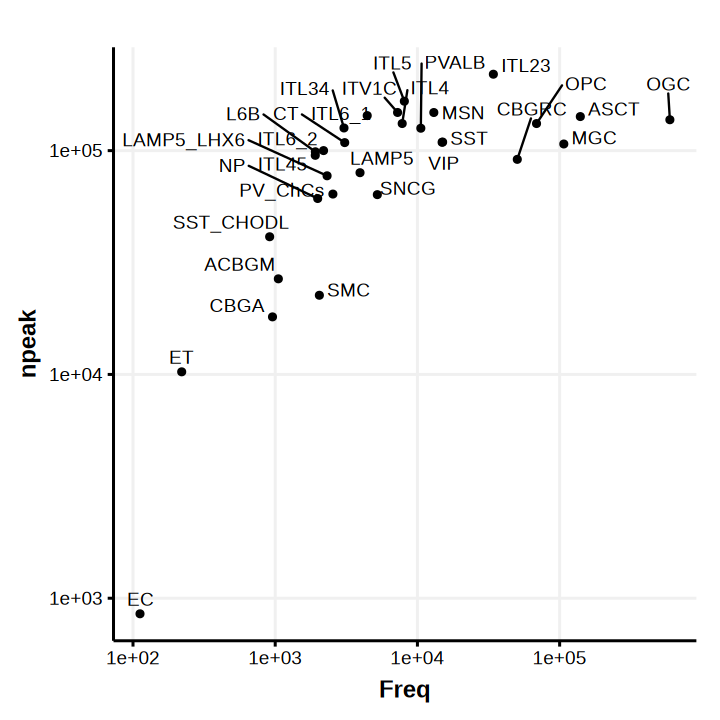

In [162]:
### Is the ATAC peaks from Yang Li also biased by cell number?
ameta <- data.table::fread("../../ref/hba_ATAC/hba_merged.metadata.csv", sep = ",")
d1 <- table(ameta$subclass) %>% as.data.frame
d2 <- list()
for (i in 1:nrow(pair_df)){
    ct <- pair_df[i, 2]
    if (!is.na(ct)){
        ccre <- read.table(paste0("../07.cCREs/cCREs/subclass/", ct, ".bed"))
        d2[[ct]] <- data.frame(Var1 = ct, npeak = nrow(ccre))
    }
}

d2 <- do.call(rbind, d2)

options(repr.plot.width = 6, repr.plot.height = 6)
merge(d1, d2, by = "Var1") %>%
ggplot(aes(x = Freq, y = npeak, label = Var1)) + 
geom_point() + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + scale_y_log10() + 
theme_Publication()

In [33]:
slist <- list()
for (f in list.files("/projects/ps-renlab2/y2xie/projects/BICAN/analysis/09.super_peaks/ROSE/H3K27ac")){
    if (file.exists(paste0("../09.super_peaks/ROSE/H3K27ac/", f, "/H3K27ac_SuperStitched.table.txt"))){
        slist[[f]] <- read.table(paste0("../09.super_peaks/ROSE/H3K27ac/", f, "/H3K27ac_SuperStitched.table.txt"), 
                                 comment.char = "#", header = T, sep = '\t') %>% 
        mutate(celltype = f, len = abs(STOP - START), range = paste0(CHROM, ":", START, "-", STOP))
    }
}

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


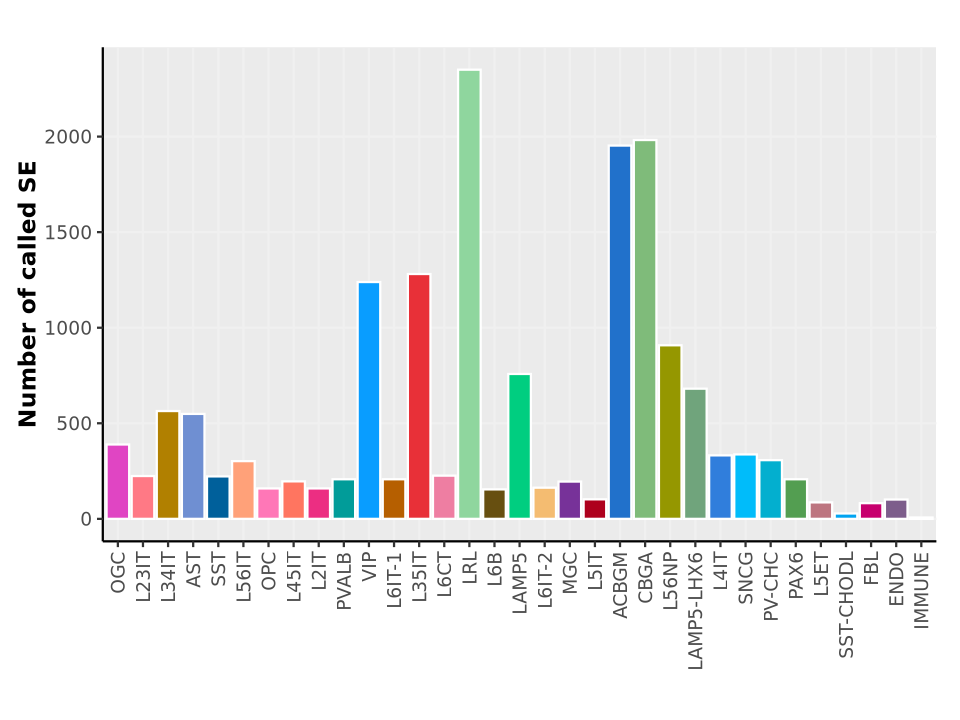

In [34]:
d2 <- table(rmeta[rmeta$target == "H3K27ac",]$subclass_corrected) %>% as.data.frame
qorder <- d2 %>% arrange(desc(Freq)) %>% dplyr::select(Var1) %>% unlist %>% as.character
lapply(slist, nrow) %>%
as.data.frame %>%
t %>% as.data.frame %>%
mutate(celltype = names(slist)) %>%
mutate(celltype = factor(celltype, levels = qorder)) %>% 
ggplot(aes(x = celltype, y = V1, fill = celltype)) + 
geom_col(color = "white") + 
theme_Publication() + xlab("") + ylab("Number of called SE") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
scale_fill_manual(values = ccol2) + NoLegend()

In [11]:
badcelltype <- c("ENDO", "IMMUNE", "L5ET", "SST-CHODL")

Warning message:
“ggrepel: 18 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


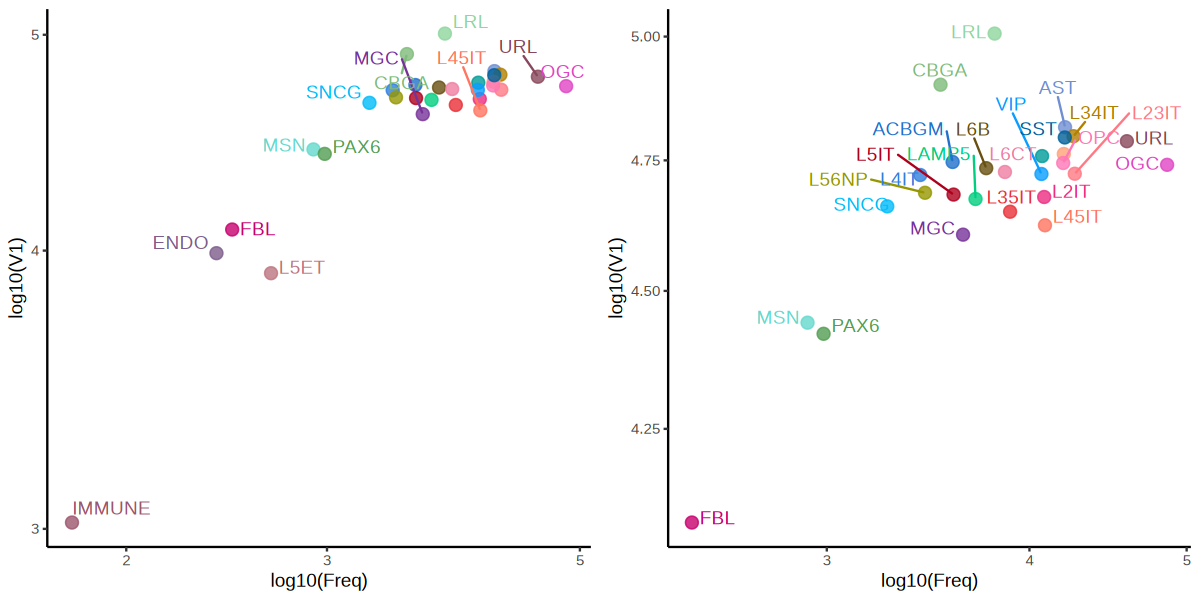

In [74]:
d1 <- data.frame(lapply(slist, function(x) median(x$len)))
d2 <- table(rmeta[rmeta$target == "H3K27ac",]$subclass_corrected) %>% as.data.frame

t1 <- merge(as.data.frame(t(d1)), d2, by.x = 0, by.y = "Var1") %>%
mutate(subclass = as.character(Row.names)) %>%
ggplot(aes(x = log10(Freq), y = log10(V1), color = subclass, label = subclass)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + scale_y_log10() + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()
                        
t2 <- merge(as.data.frame(t(d1)), d2, by.x = 0, by.y = "Var1") %>%
mutate(subclass = as.character(Row.names)) %>% 
filter(!(subclass %in% badcelltype)) %>%
ggplot(aes(x = log10(Freq), y = log10(V1), color = subclass, label = subclass)) + 
geom_point(size = 3, alpha = 0.8) + 
ggrepel::geom_text_repel(size = 4, vjust = 1.5, hjust = 0.5) +
scale_x_log10() + scale_y_log10() + 
theme_classic() + scale_color_manual(values = ccol2) + NoLegend()
                        
options(repr.plot.width = 10, repr.plot.height = 5)
cowplot::plot_grid(t1, t2, ncol = 2)

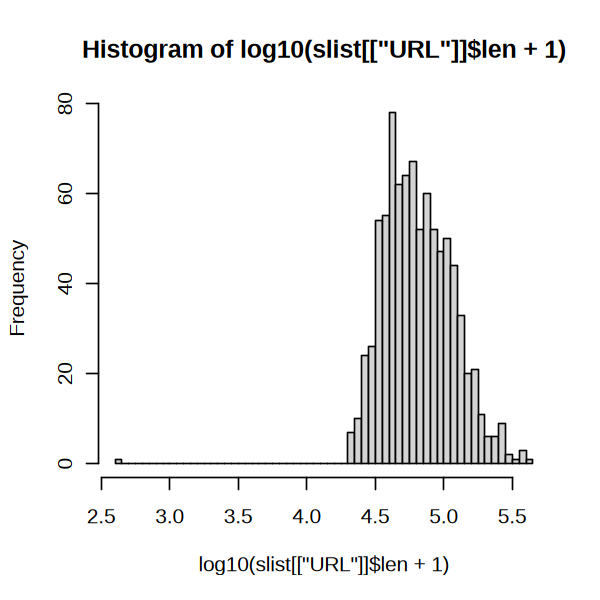

In [36]:
### 100 folds length diff?
hist(log10(slist[["URL"]]$len+1), breaks = 50)

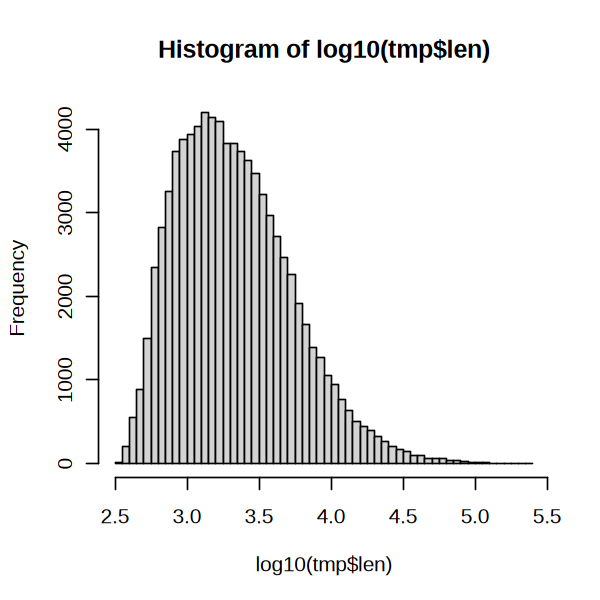

In [41]:
f <- "URL.naivePeakList.narrowPeak.gz"
tmp <- read.table(paste0("250601/parseK27ac/", f)) %>%
dplyr::select(V1, V2, V3) %>% distinct %>%
mutate(len = V3 - V2)

options(repr.plot.width = 5, repr.plot.height = 5)
hist(log10(tmp$len), breaks = 50)

In [110]:
### H3K27ac

In [ ]:
for (f in list.files("/tscc/projects/ps-renlab2/y2xie/projects/BICAN/analysis/05.peaks_calling/LRtest", pattern = ".csv")){
    file <- read.csv(paste0("/tscc/projects/ps-renlab2/y2xie/projects/BICAN/analysis/05.peaks_calling/LRtest/", f))
    fname <- gsub("K27ac_acpeak_LR_([^.]+).csv", "\\1", f)
    tmp <- file %>% dplyr::filter(adjusted.p.value	< 0.05, log2.fold_change. > 0.1)
    tmp[,c("chrom", "start", "end")] <- stringr::str_split_fixed(tmp$feature.name, pattern = "[-:]", n = 3)
    print(nrow(tmp))

    write.table(tmp[,c("chrom", "start", "end", "feature.name", "log2.fold_change.", "adjusted.p.value", "subclass_corrected")],
                paste0("/tscc/projects/ps-renlab2/y2xie/projects/BICAN/analysis/05.peaks_calling/LRtest/bed/", fname, "_K27ac_acpeak_LR.bed"), sep = "\t", quote = F, row.names = F, col.names = F)
}

## Annotate snm3c loops with histone peak results

In [ ]:
### After getting loops list from Jintian, we use FitHiC2 `merge-filter.sh` to 
### retain only the most significant pixels among multiple pixels

In [260]:
ac10 <- read.csv("MiniAtlas_H3K27ac.10kb_251002.subclass_corrected.cpm.csv", row.names = 1, check.names = F)
me10 <- read.csv("MiniAtlas_H3K27me3.10kb_251002.subclass_corrected.cpm.csv", row.names = 1, check.names = F)

In [ ]:
### Requireument: 
### need to overlap 30% peaks.
### if a peak overlap with peaks from two marks, determine using mark signal logFC > 1

In [261]:
reciprocal_overlaps <- function(query, subject, f = 0.3, F = 0) {
    hits <- findOverlaps(query, subject, ignore.strand = TRUE)
    if (length(hits) == 0L) return(hits)
    q <- queryHits(hits); s <- subjectHits(hits)
    ovl <- pintersect(ranges(query)[q], ranges(subject)[s])
    ovl_w <- width(ovl)
    keep <- (ovl_w >= f * width(query)[q]) & (ovl_w >= F * width(subject)[s])
    hits[keep]
}

In [475]:
### loop anchors analysis
### need to overlap 30% peaks.
### if a peak overlap with peaks from two marks, determine using mark signal logFC > 1
olist1 <- olist2 <- flist <- list()
for (i in 1:nrow(pair_df2)){
    ct1 <- pair_df2[i, "MiniAtlas"]
    ct2 <- pair_df2[i, "snm3c"]
    ct2 <- gsub("-", "_", ct2)
    ct2 <- gsub("\\/", "", ct2)
    if (!(ct2 %in% c('MSN_D2')) & !is.na(ct2)){
        loop <- read.table(paste0("../../ref/hba_snm3c/loop/FitHiC_filter/", ct2, ".loop.bedpe"))        
        l1 <- loop[,1:3] %>% distinct
        l2 <- loop[,4:6] %>% distinct %>% setNames(colnames(l1))
        loop_anchors <- rbind(l1, l2) %>% distinct
        looprange <- GRanges(loop_anchors[,1], ranges = IRanges(as.numeric(loop_anchors[,2]), as.numeric(loop_anchors[,3])))
        
        ### H3K27me3
        p1 <- read.table(paste0("250601/parseK27me3/", ct1, ".naivePeakList.broadPeak.gz")) %>%
        dplyr::select(V1, V2, V3) %>% distinct
        prange1 <- GRanges(p1[,1], ranges = IRanges(as.integer(p1[,2]), as.integer(p1[,3])))
        flp <- reciprocal_overlaps(prange1, looprange, f = 0.3, F = 0)
        
        tmp <- cbind(p1[queryHits(flp),], loop_anchors[subjectHits(flp),]) %>% 
        setNames(c("pchr", "pstart", "pend", "lchr", "lstart", "lend")) %>%
        mutate(range1 = paste0(pchr, ":", as.integer(pstart), "-", as.integer(pend)), 
               range2 = paste0(lchr, ":", as.integer(lstart), "-", as.integer(lend))) %>%
        mutate(celltype = ct1, target = "H3K27me3")
        
        tmp$ac_siganl <- ac10[tmp$range2, ct1] + pi
        tmp$me3_signal <- me10[tmp$range2, ct1] + pi
        tmp$ac_vs_me <- log2(tmp$ac_siganl/tmp$me3_signal)
        olist1[[i]] <- tmp %>% 
        mutate(type = ifelse(ac_vs_me >= 1, "conflict", "unknown")) %>%
        mutate(type = ifelse(ac_vs_me <= -1, "confident", type))

        ### H3K27ac
        p2 <- read.table(paste0("250601/parseK27ac/", ct1, ".naivePeakList.narrowPeak.gz")) %>%
        dplyr::select(V1, V2, V3) %>% distinct
        prange2 <- GRanges(p2[,1], ranges = IRanges(as.integer(p2[,2]), as.integer(p2[,3])))
        flp <- reciprocal_overlaps(prange2, looprange, f = 0.3, F = 0)
        
        tmp <- cbind(p2[queryHits(flp),], loop_anchors[subjectHits(flp),]) %>% 
        setNames(c("pchr", "pstart", "pend", "lchr", "lstart", "lend")) %>%
        mutate(range1 = paste0(pchr, ":", as.integer(pstart), "-", as.integer(pend)), 
               range2 = paste0(lchr, ":", as.integer(lstart), "-", as.integer(lend))) %>%
        mutate(celltype = ct1, target = "H3K27ac")
        tmp$ac_siganl <- ac10[tmp$range2, ct1] + pi
        tmp$me3_signal <- me10[tmp$range2, ct1] + pi
        tmp$ac_vs_me <- log2(tmp$ac_siganl/tmp$me3_signal)
        olist2[[i]] <- tmp %>% 
        mutate(type = ifelse(ac_vs_me <= -1, "conflict", "unknown")) %>%
        mutate(type = ifelse(ac_vs_me >= 1, "confident", type))

        tmp <- olist1[[i]]
        tmp2 <- olist2[[i]]
        urange1 <- setdiff(tmp$range2, tmp2$range2)
        urange2 <- setdiff(tmp2$range2, tmp$range2)
        srange <- intersect(tmp$range2, tmp2$range2)
        qpair <- rbind(tmp[tmp$range2 %in% urange1,], tmp2[tmp2$range2 %in% urange2,])
        if (length(srange) > 0){
            qpair2 <- tmp[tmp$range2 %in% srange,] %>%
            mutate(target = ifelse(ac_vs_me >= 1, "H3K27ac", target),
                   type = ifelse(ac_vs_me >= 1, "mix_confident", "unknown")) %>%
            mutate(target = ifelse(ac_vs_me <= -1, "H3K27me3", target),
                   type = ifelse(ac_vs_me <= -1, "mix_confident", type))
            flist[[i]] <- rbind(qpair, qpair2)
        }else{
            flist[[i]] <- qpair
        }
    }
}

flist <- do.call(rbind, flist)

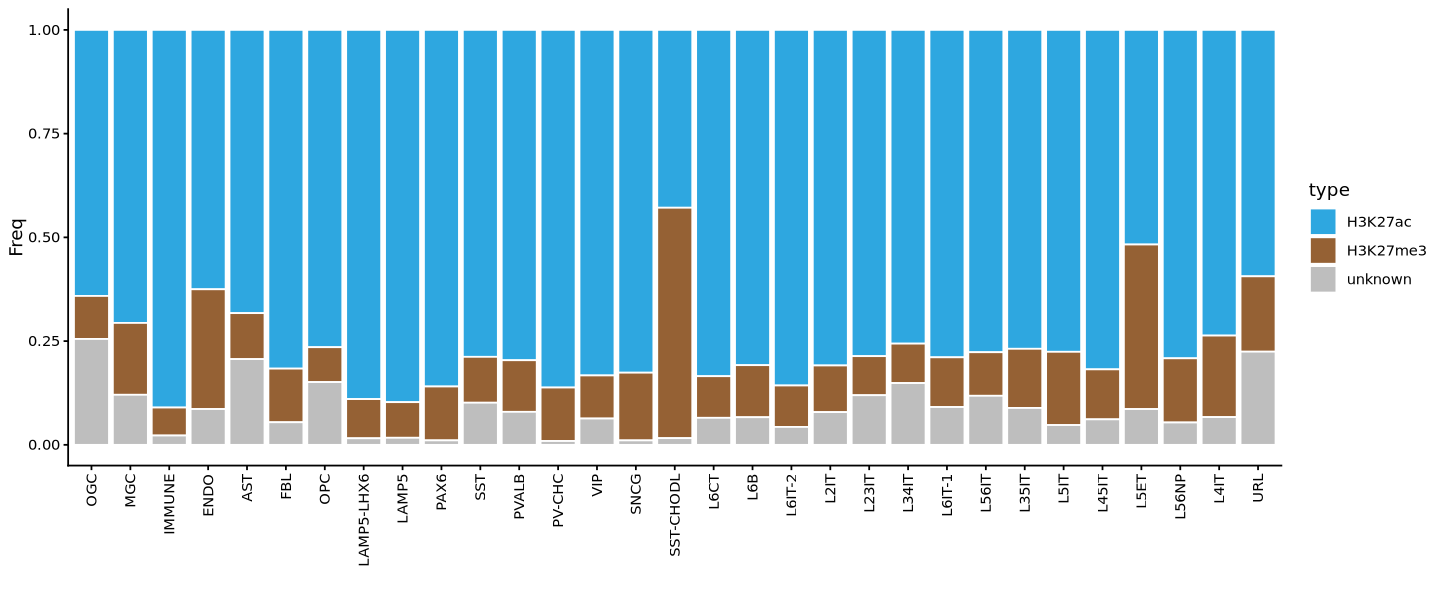

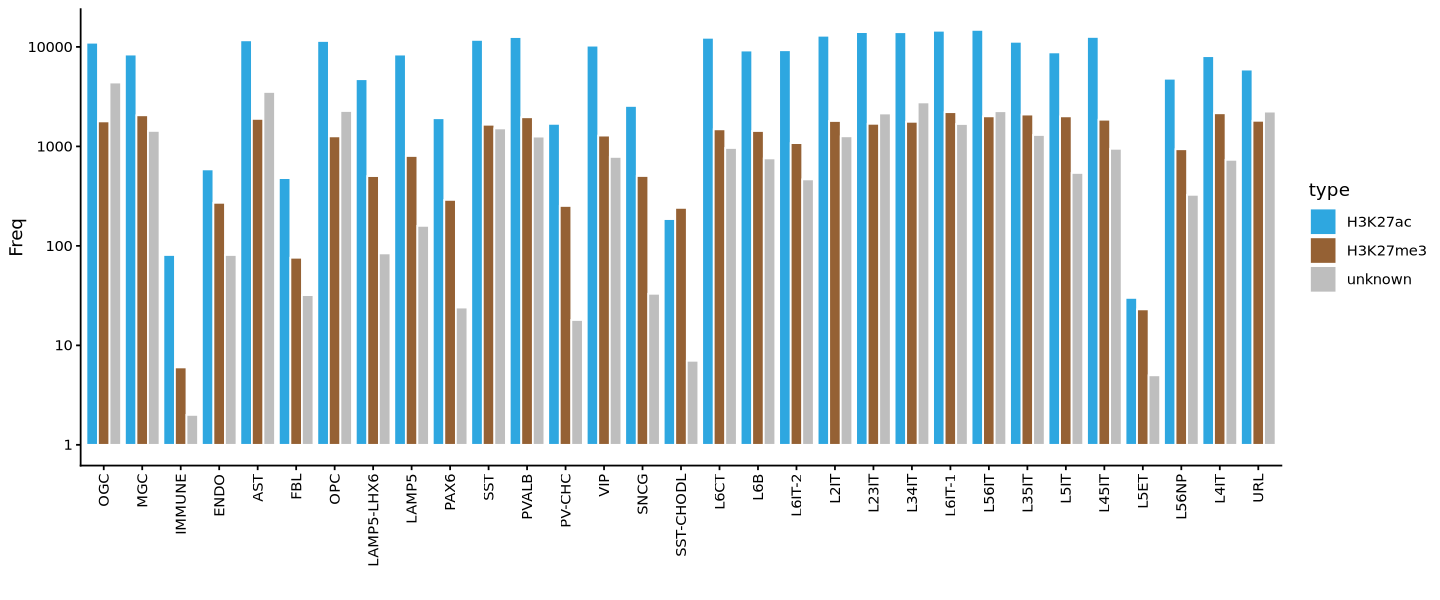

In [479]:
### Merge labels
badcelltype <- c("ENDO", "IMMUNE", "L5ET", "SST-CHODL", "MSN")

options(repr.plot.width = 12, repr.plot.height = 5)
flist[,c("range2", "target", "type", "celltype")] %>%
distinct %>% 
mutate(type = ifelse(type %in% c("conflict", "unknown"), "unknown", type)) %>%
mutate(type = ifelse(type %in% c("confident", "mix_confident"), "confident", type)) %>%
mutate(type = ifelse(type == "confident", target, "unknown")) %>%
dplyr::select(type, celltype) %>%
table %>% as.data.frame %>%
mutate(celltype = factor(celltype, levels = corder)) %>%
ggplot(aes(x = celltype, y = Freq, fill = type)) +
geom_col(position = "fill", color = "white") + 
theme_classic() + xlab("") + scale_fill_manual(values = c("#2EA7E0", "#956134", "grey")) +  
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

flist[,c("range2", "target", "type", "celltype")] %>%
distinct %>% 
mutate(type = ifelse(type %in% c("conflict", "unknown"), "unknown", type)) %>%
mutate(type = ifelse(type %in% c("confident", "mix_confident"), "confident", type)) %>%
mutate(type = ifelse(type == "confident", target, "unknown")) %>%
dplyr::select(type, celltype) %>%
table %>% as.data.frame %>%
mutate(celltype = factor(celltype, levels = corder)) %>%
ggplot(aes(x = celltype, y = Freq, fill = type)) +
geom_col(position = "dodge", color = "white") + 
scale_y_log10() + 
theme_classic() + xlab("") + scale_fill_manual(values = c("#2EA7E0", "#956134", "grey")) +  
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [496]:
### Plot all loops anchors
qflist <- flist %>%
mutate(type = ifelse(type %in% c("conflict", "unknown"), "unknown", type)) %>%
mutate(type = ifelse(type %in% c("confident", "mix_confident"), "confident", type)) %>%
mutate(type = ifelse(type == "confident", target, "unknown")) 

olist3 <- list()
for (i in 1:nrow(pair_df2)){
    ct1 <- pair_df2[i, "MiniAtlas"]
    ct2 <- pair_df2[i, "snm3c"]
    ct2 <- gsub("-", "_", ct2)
    ct2 <- gsub("\\/", "", ct2)
    if (!is.na(ct2)){        
        loop <- read.table(paste0("../../ref/hba_snm3c/loop/FitHiC_filter/", ct2, ".loop.bedpe")) # %>% filter(V7 >= 0.5)
        l1 <- loop[,1:3] %>% distinct
        l2 <- loop[,4:6] %>% distinct %>% setNames(colnames(l1))
        loop_anchors <- rbind(l1, l2) %>% distinct %>% 
        mutate(range = paste0(V1, ":", as.integer(V2), "-", as.integer(V3))) %>% dplyr::select(range)
        qlist <- qflist %>% filter(celltype == ct1)
        olist3[[ct1]] <- merge(loop_anchors, qlist, by.x = "range", by.y = "range2", all.x = T) %>%
        mutate(type = ifelse(is.na(type), "unknown", type)) %>%
        mutate(celltype = ct1)
    }
}
olist3 <- do.call(rbind, olist3)

In [498]:
qorder <- olist3 %>% dplyr::select(type, range, celltype) %>% 
distinct %>% dplyr::select(celltype, type) %>% table %>% as.data.frame %>% 
group_by(celltype) %>% mutate(ratio = Freq/sum(Freq)) %>% ungroup %>%
filter(type == "H3K27ac") %>% arrange(desc(ratio)) %>% 
dplyr::select(celltype) %>% unlist %>% as.character

In [499]:
### Plot all loops
olist4 <- list()
for (i in 1:nrow(pair_df2)){
    ct1 <- pair_df2[i, "MiniAtlas"]
    ct2 <- pair_df2[i, "snm3c"]
    ct2 <- gsub("-", "_", ct2)
    ct2 <- gsub("\\/", "", ct2)
    if (!is.na(ct2)){        
        loop <- read.table(paste0("../../ref/hba_snm3c/loop/FitHiC_filter/", ct2, ".loop.bedpe"))
        loop <- loop %>% mutate(range1 = paste0(V1, ":", as.integer(V2), "-", as.integer(V3)), 
                                range2 = paste0(V4, ":", as.integer(V5), "-", as.integer(V6))) %>%
        dplyr::select(range1, range2)
        qlist <- qflist %>% filter(celltype == ct1) %>% dplyr::select(range2, type)
        t1 <- merge(loop, qlist, by.x = "range1", by.y = "range2", all.x = T)
        t2 <- merge(loop, qlist, by = "range2", all.x = T)
        
        olist4[[ct1]] <- merge(t1, t2, by = c("range1", "range2"), all = T) %>%
        mutate(type.x = ifelse(is.na(type.x), "unknown", type.x)) %>% # mutate(celltype = ct1) 
        mutate(type.y = ifelse(is.na(type.y), "unknown", type.y)) %>% 
        mutate(ltype = ifelse(type.x == "H3K27ac" & type.y == "H3K27ac", "H3K27ac", "unknown")) %>%
        mutate(ltype = ifelse(type.x == "H3K27me3" & type.y == "H3K27me3", "H3K27me3", ltype)) %>%
        mutate(ltype = ifelse(type.x != type.y & type.y != "unknown" & type.x != "unknown", "mix", ltype)) %>%
        mutate(celltype = ct1)
    }
}

olist4 <- do.call(rbind, olist4)

In [103]:
olist4$celltype %>% unique %>% length
olist4 %>% filter(ltype %in% c("H3K27ac", "H3K27me3")) %>% 
dplyr::select(range1, range2) %>% distinct %>% nrow
olist4 %>% dplyr::select(range1, range2) %>% distinct %>% nrow

[1] 32

[1] 70623

[1] 203125

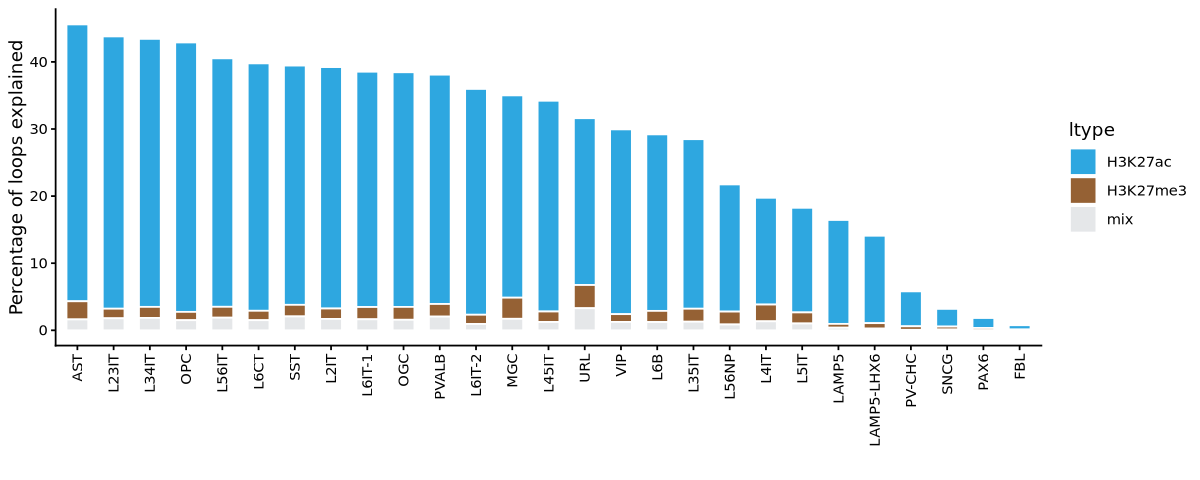

In [503]:
qorder <- olist4 %>% distinct %>% dplyr::select(celltype, ltype) %>% table %>% as.data.frame %>%
group_by(celltype) %>% mutate(ratio = Freq/sum(Freq)) %>% ungroup %>%
filter(ltype == "unknown") %>%
arrange(ratio) %>% dplyr::select(celltype) %>% unlist %>% as.character

t1 <- olist4 %>% distinct %>%
dplyr::select(ltype, celltype) %>% table %>% as.data.frame %>% 
group_by(celltype) %>% mutate(ratio = Freq/sum(Freq)) %>% ungroup %>%
filter(ltype != "unknown") %>%
filter(!(celltype %in% badcelltype)) %>%
mutate(celltype = factor(celltype, levels = qorder)) %>%
ggplot(aes(x = celltype, y = 100*ratio, fill = ltype)) +
geom_col(width = 0.6, position = "stack", color = "white") + 
theme_classic() + xlab("") + ylab("Percentage of loops explained") + 
scale_fill_manual(values = c("#2EA7E0", "#956134", "#E5E7E9")) +  #, "#909497"
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

options(repr.plot.width = 10, repr.plot.height = 4)
t1

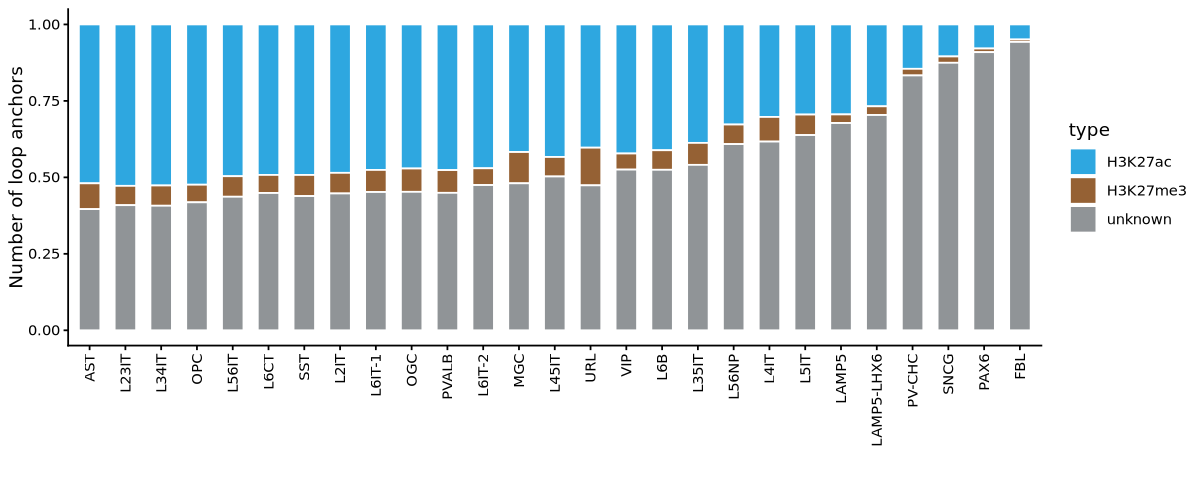

In [505]:
### plot anchors in the same order
t1 <- olist3 %>% dplyr::select(type, range, celltype) %>% distinct %>%
dplyr::select(type, celltype) %>% table %>% as.data.frame %>% 
filter(!(celltype %in% badcelltype)) %>%
mutate(celltype = factor(celltype, levels = qorder)) %>%
ggplot(aes(x = celltype, y = Freq, fill = type)) +
geom_col(width = 0.6, position = "fill", color = "white") + 
theme_classic() + xlab("") + ylab("Number of loop anchors") + 
scale_fill_manual(values = c("#2EA7E0", "#956134", "#909497")) + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

options(repr.plot.width = 10, repr.plot.height = 4)
t1

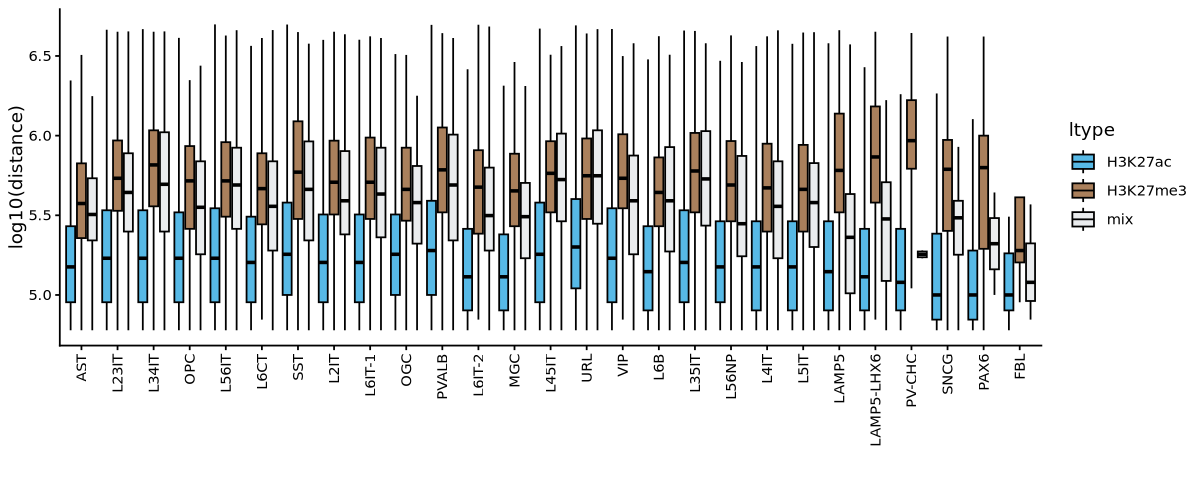

In [511]:
### Compare distance distribution
olist4[,c("chrom1", "start1", "end1")] <- stringr::str_split_fixed(olist4$range1, pattern = "[:-]", n = 3)
olist4[,c("chrom2", "start2", "end2")] <- stringr::str_split_fixed(olist4$range2, pattern = "[:-]", n = 3)

t1 <- olist4 %>% mutate(distance = abs(as.integer(start1) - as.integer(start2))) %>%
filter(ltype != "unknown") %>%
filter(!(celltype %in% badcelltype)) %>%
mutate(celltype = factor(celltype, levels = qorder)) %>%
ggplot(aes(x = celltype, y = log10(distance), fill = ltype)) + 
# geom_violin() + 
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
theme_classic() + xlab("") + 
scale_fill_manual(values = c("#2EA7E0", "#956134", "#E5E7E9")) +  #, "#909497"
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

options(repr.plot.width = 10, repr.plot.height = 4)
t1

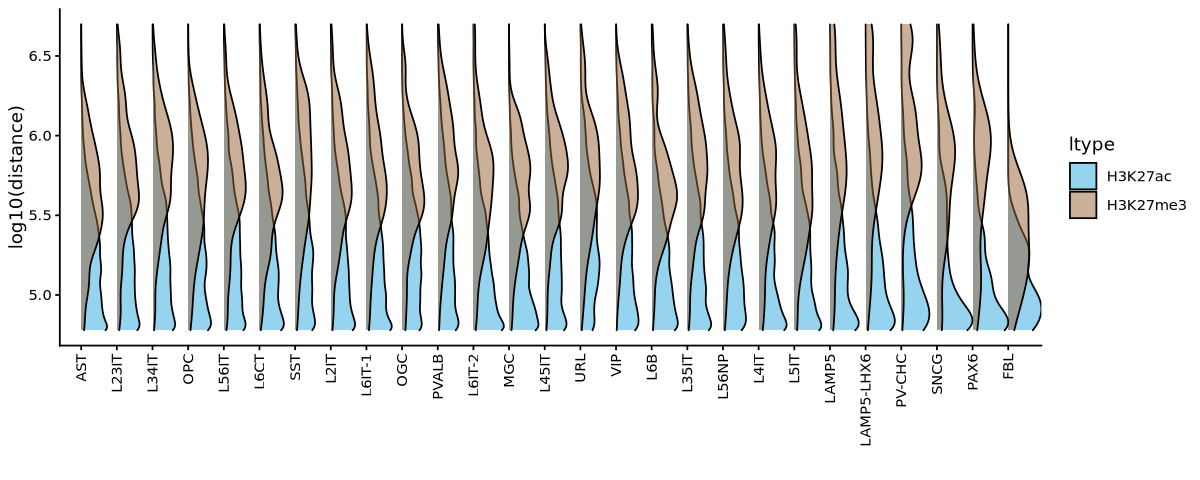

In [512]:
t1 <- olist4 %>% mutate(distance = abs(as.integer(start1) - as.integer(start2))) %>%
filter(ltype %in% c("H3K27ac", "H3K27me3")) %>%
filter(!(celltype %in% badcelltype)) %>%
mutate(celltype = factor(celltype, levels = qorder)) %>%
ggplot(aes(y = celltype, x = log10(distance), height = after_stat(density))) + 
geom_density_ridges(aes(fill = ltype), alpha = 0.5, scale = 1, stat = "density") + 
theme_classic() + xlab("log10(distance)") + ylab("") + 
scale_fill_manual(values = c("#2EA7E0", "#956134")) +  #, "#909497", "#E5E7E9"
coord_flip() + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

options(repr.plot.width = 10, repr.plot.height = 4)
t1

## Check overlap with SS / SE

In [117]:
sslist <- list()
for (fname in list.files("../../analysis/09.super_peaks/ROSE/H3K27me3/")){
    if (fname != "MSN"){
        tmp <- read.table(paste0("../../analysis/09.super_peaks/ROSE/H3K27me3/", fname, "/H3K27me3_AllStitched.table.txt"),
                          comment.char = "#", header = T, sep = '\t') ### read all
        sslist[[fname]] <- tmp %>% 
        setNames(c("id", "chrom", "start", "end", "nloci", "size", "bam", "rank", "isSuper")) %>%
        mutate(celltype = fname, len = abs(end - start), range = paste0(chrom, ":", start, "-", end))
    }
}

sslist <- do.call(rbind, sslist)

In [121]:
### All celltypes comparsion
qlist <- list()
for (f in unique(olist4$celltype)){
    tmp1 <- olist4 %>% filter(ltype == "H3K27me3", celltype == f) %>% dplyr::select(chrom1, start1, end1) 
    tmp2 <- olist4 %>% filter(ltype == "H3K27me3", celltype == f) %>% dplyr::select(chrom2, start2, end2) %>% 
    setNames(c('chrom1', 'start1', 'end1'))
    tmp1 <- rbind(tmp1, tmp2) %>% distinct
    lrange1 <- GRanges(tmp1[,1], ranges = IRanges(as.integer(tmp1[,2]), as.integer(tmp1[,3])))
    slist <- list()
    for (k in setdiff(unique(olist4$celltype), badcelltype)){
        tmp2 <- sslist %>% filter(celltype == k, isSuper == 1) %>% dplyr::select(chrom, start, end) %>% distinct ### SS
        tmp3 <- sslist %>% filter(celltype == k, isSuper == 0) %>% dplyr::select(chrom, start, end) %>% distinct ### common peaks
        lrange2 <- GRanges(tmp2[,1], ranges = IRanges(as.integer(tmp2[,2]), as.integer(tmp2[,3])))
        qov <- subjectHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length
        sov <- queryHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length

        lrange3 <- GRanges(tmp3[,1], ranges = IRanges(as.integer(tmp3[,2]), as.integer(tmp3[,3])))
        qov2 <- subjectHits(findOverlaps(lrange1, lrange3)) %>% unique %>% length
        sov2 <- queryHits(findOverlaps(lrange1, lrange3)) %>% unique %>% length
        
        slist[[k]] <- data.frame(nsuper = nrow(tmp2), ncommon = nrow(tmp3), nqry = nrow(tmp1), 
                                 novlp_super = qov, novlp_super_loop = sov, 
                                 novlp_common = qov2, novlp_common_loop = sov2, 
                                 qcelltype = f, rcelltype = k)
    }
    qlist[[f]] <- do.call(rbind, slist)
}
qlist <- do.call(rbind, qlist)

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11
  - in 'y': chrX
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”
Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr11
  - in 'y': chrX
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”
Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr1, chr10, chr17, chr3, chr6, chr7, chr8
  - in 'y': chrX
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”
Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects

Using group as id variables

Warning message:
“Removed 64 rows containing non-finite outside the scale range (`stat_boxplot()`).”


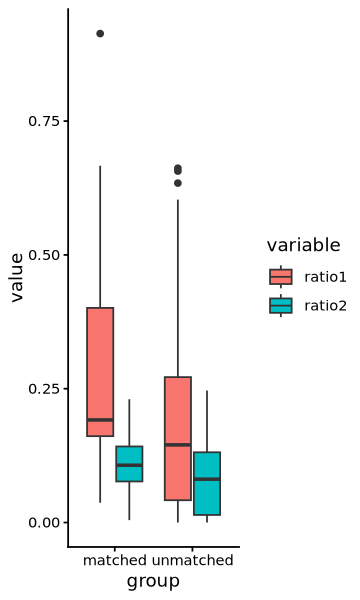

In [128]:
qlist %>% 
mutate(ratio1 = novlp_super/nsuper, ratio2 = novlp_common/ncommon) %>%
mutate(group = ifelse(qcelltype == rcelltype, "matched", "unmatched")) %>%
dplyr::select(group, ratio1, ratio2) %>%
reshape2::melt() %>%
ggplot(aes(x = group, y = value, fill = variable)) + 
geom_boxplot() + 
theme_classic()

In [129]:
### read super enhancers
selist <- list()
for (fname in list.files("../../analysis/09.super_peaks/ROSE/H3K27ac/")){
    if (fname != "MSN"){
        tmp <- read.table(paste0("../../analysis/09.super_peaks/ROSE/H3K27ac/", fname, "/H3K27ac_AllStitched.table.txt"),
                                  comment.char = "#", header = T, sep = '\t') ### read all
        selist[[fname]] <- tmp %>% 
        setNames(c("id", "chrom", "start", "end", "nloci", "size", "bam", "rank", "isSuper")) %>%
        mutate(celltype = fname, len = abs(end - start), range = paste0(chrom, ":", start, "-", end))
    }
}
selist <- do.call(rbind, selist)

### All celltypes comparsion
qlist2 <- list()
for (f in unique(olist4$celltype)){
    tmp1 <- olist4 %>% filter(ltype == "H3K27ac", celltype == f) %>% dplyr::select(chrom1, start1, end1) 
    tmp2 <- olist4 %>% filter(ltype == "H3K27ac", celltype == f) %>% dplyr::select(chrom2, start2, end2) %>% setNames(c('chrom1', 'start1', 'end1'))
    tmp1 <- rbind(tmp1, tmp2) %>% distinct
    lrange1 <- GRanges(tmp1[,1], ranges = IRanges(as.integer(tmp1[,2]), as.integer(tmp1[,3])))
    slist <- list()
    for (k in setdiff(unique(olist4$celltype), badcelltype)){
        tmp2 <- selist %>% filter(celltype == k, isSuper == 1) %>% dplyr::select(chrom, start, end) %>% distinct ### SS
        tmp3 <- selist %>% filter(celltype == k, isSuper == 0) %>% dplyr::select(chrom, start, end) %>% distinct ### common peaks
        lrange2 <- GRanges(tmp2[,1], ranges = IRanges(as.integer(tmp2[,2]), as.integer(tmp2[,3])))
        qov <- subjectHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length
        sov <- queryHits(findOverlaps(lrange1, lrange2)) %>% unique %>% length

        lrange3 <- GRanges(tmp3[,1], ranges = IRanges(as.integer(tmp3[,2]), as.integer(tmp3[,3])))
        qov2 <- subjectHits(findOverlaps(lrange1, lrange3)) %>% unique %>% length
        sov2 <- queryHits(findOverlaps(lrange1, lrange3)) %>% unique %>% length
        
        slist[[k]] <- data.frame(nsuper = nrow(tmp2), ncommon = nrow(tmp3), nqry = nrow(tmp1), 
                                 novlp_super = qov, novlp_super_loop = sov, 
                                 novlp_common = qov2, novlp_common_loop = sov2, 
                                 qcelltype = f, rcelltype = k)
    }
    qlist2[[f]] <- do.call(rbind, slist)
}
qlist2 <- do.call(rbind, qlist2)

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr13, chr18, chr19
  - in 'y': chrX
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”
Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr13, chr18, chr19
  - in 'y': chrX
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”
Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr19
  - in 'y': chr21
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”
Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has seq

Using group as id variables

Warning message:
“Removed 64 rows containing non-finite outside the scale range (`stat_boxplot()`).”


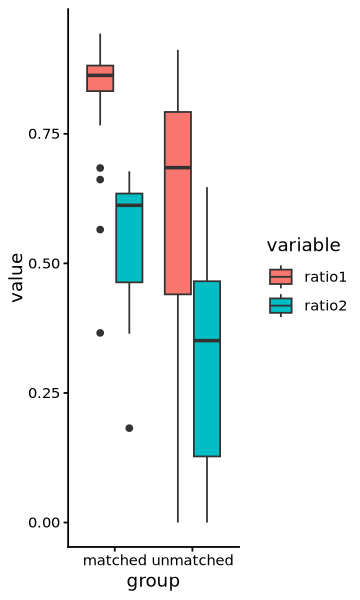

In [130]:
qlist2 %>% 
mutate(ratio1 = novlp_super/nsuper, ratio2 = novlp_common/ncommon) %>%
mutate(group = ifelse(qcelltype == rcelltype, "matched", "unmatched")) %>%
dplyr::select(group, ratio1, ratio2) %>%
reshape2::melt() %>%
ggplot(aes(x = group, y = value, fill = variable)) + 
geom_boxplot() + 
theme_classic()

Using target, group as id variables



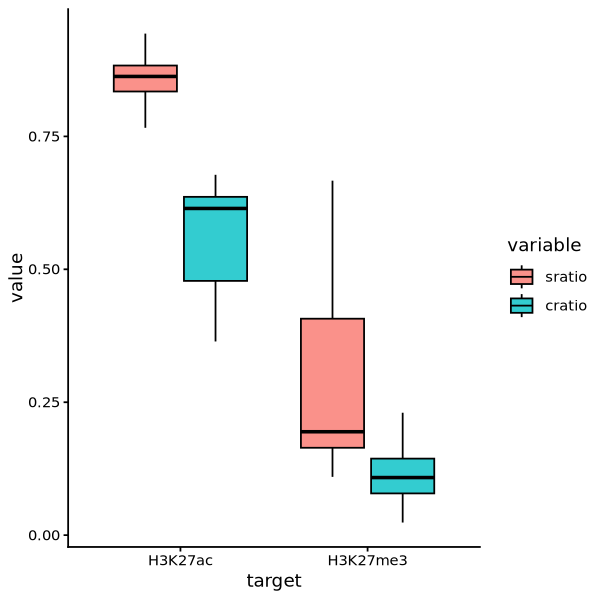

In [137]:
### add in non-super peaks for comparsion
t1 <- rbind(qlist %>% mutate(target = "H3K27me3"), 
qlist2 %>% mutate(target = "H3K27ac")) %>%
mutate(sratio = novlp_super/nsuper, cratio = novlp_common/ncommon) %>%
mutate(group = ifelse(qcelltype == rcelltype, "matched", "unmatched")) %>%
filter(group == "matched", !(rcelltype %in% badcelltype2)) %>%
dplyr::select(target, group, sratio, cratio) %>%
reshape2::melt() %>%
ggplot(aes(x = target, y = value, fill = variable)) + 
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA) + 
# geom_jitter() + 
theme_classic() # + scale_fill_manual(values = c("#2EA7E0", "#956134", "#E5E7E9", "#909497"))

options(repr.plot.width = 5, repr.plot.height = 5)
t1

## Quantify loops strength

In [641]:
### Use APA for calculated avg strength across cell types
system("mkdir /projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/loop/FitHiC_filter/histone_classify/")
for (f in unique(olist4$celltype)){
    qdf <- olist4 %>% filter(celltype == f) 
    for (cls in unique(qdf$ltype)){
        loop <- qdf %>% filter(ltype == cls) %>% dplyr::select(chrom1,start1,end1,chrom2,start2,end2)
        loop$start1 <- as.integer(loop$start1)
        loop$end1 <- as.integer(loop$end1)
        loop$start2 <- as.integer(loop$start2)
        loop$end2 <- as.integer(loop$end2)
        write.table(loop, paste0("/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/loop/FitHiC_filter/histone_classify/", f, "_", cls, ".bedpe"), 
                    sep = "\t", quote = F, row.names = F, col.names = F)
    }
}

tmp <- pair_df2 %>% filter(!is.na(snm3c)) 
tmp$snm3c <- gsub("-", "_", tmp$snm3c)
tmp$snm3c <- gsub("\\/", "", tmp$snm3c)
write.table(tmp, "/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/loop/FitHiC_filter/histone_classify/match.txt", 
            row.names = F, col.names = F, sep = "\t", quote = F)

In [704]:
pulist <- read.csv('/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/loop/FitHiC_filter/histone_classify/cooltools_pileup_ooe.csv', row.names = 1)
t1 <- pulist %>%
mutate(celltype = gsub("([^_]+)_([^_]+)", "\\1", loopfile)) %>%
mutate(target = gsub("([^_]+)_([^_]+)", "\\2", loopfile)) %>%
filter(!(celltype %in% badcelltype)) %>%
ggplot(aes(x = target, y = log2(ooe), fill = target)) +
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
theme_classic() + ylab("log2(ooe)") + 
scale_fill_manual(values = c("#2EA7E0", "#956134", "#E5E7E9", "#909497")) +  
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + NoLegend()

In [523]:
compute_p2ll <- function(pile) {
    W <- nrow(pile)
    center <- floor(W / 2) + 1  # R indexes from 1

    # center pixel
    peak <- pile[center, center]

    # lower-left quadrant
    ll <- pile[(center+1):W, 1:(center-1)]

    # P2LL score
    peak / mean(ll, na.rm = TRUE)
}

In [647]:
library(reticulate)
np <- import("numpy")
pumtx <- np$load("/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/loop/FitHiC_filter/histone_classify/cooltools_pileup.npz")
keys <- pumtx$files
pumtx <- lapply(keys, function(k) {
  x <- pumtx[[k]]
  if (inherits(x, "numpy.ndarray")) {
    x <- py_to_r(x)
  }

  return(x)
})

names(pumtx) <- keys

In [685]:
klist <- list()
for (x in keys){
    parts <- strsplit(x, "_")[[1]]
    last <- tail(parts, 1)          
    second_last <- tail(parts, 2)[1]
    klist[[x]] <- data.frame(x, last, second_last)
}

klist <- do.call(rbind, klist) %>% setNames(c("fname", "target", "celltype"))

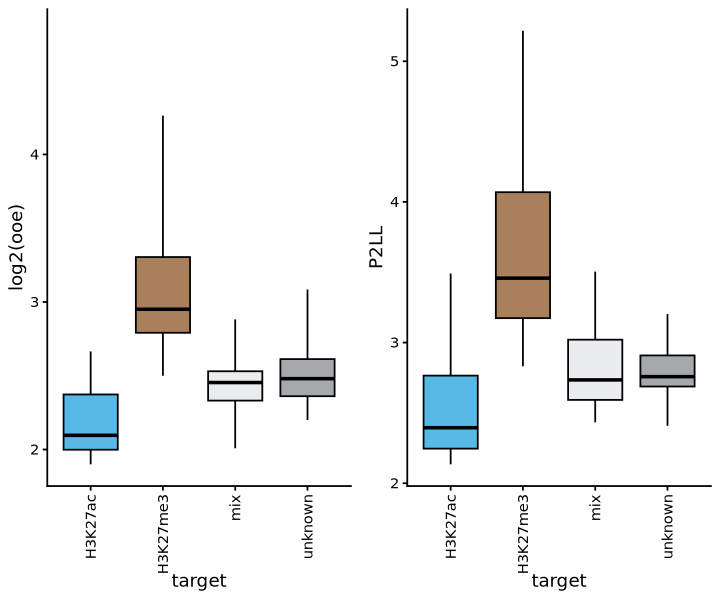

In [705]:
df <- lapply(pumtx, function(x) compute_p2ll(as.matrix(x))) %>% as.data.frame %>% t %>% 
as.data.frame %>% tibble::rownames_to_column("fname")

t2 <- merge(df, klist, by = 'fname') %>%
filter(!(celltype %in% badcelltype)) %>%
ggplot(aes(x = target, y = V1, fill = target)) +
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
theme_classic() + ylab("P2LL") + 
scale_fill_manual(values = c("#2EA7E0", "#956134", "#E5E7E9", "#909497")) +  
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + NoLegend()


options(repr.plot.width = 6, repr.plot.height = 5)
fig1 <- cowplot::plot_grid(t1, t2, ncol = 2)
fig1

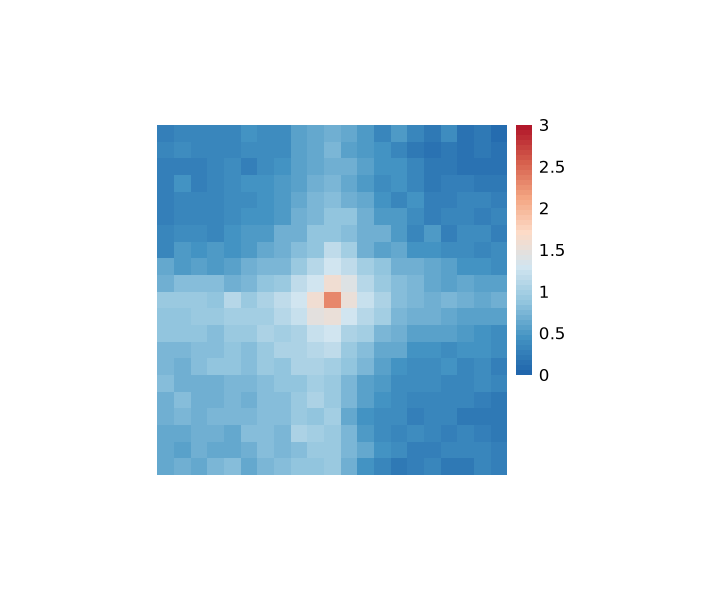

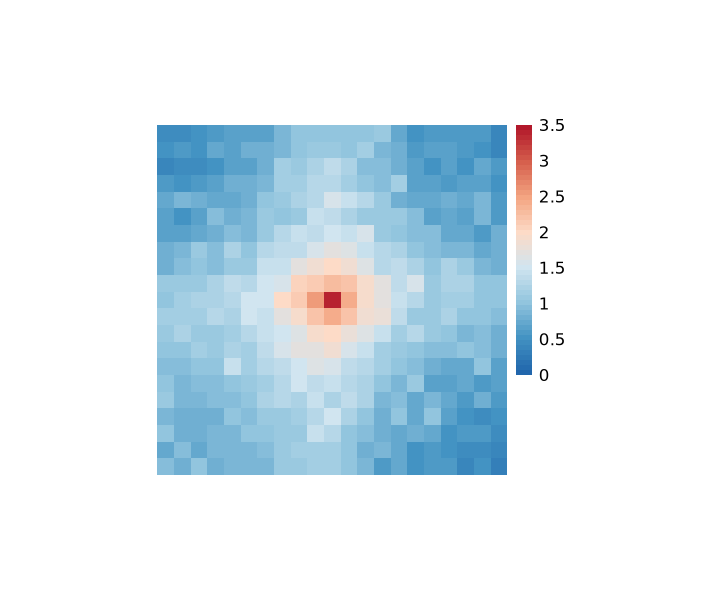

In [702]:
mat_list <- pumtx[grep("H3K27ac", names(pumtx))]
avg_mat <- Reduce("+", lapply(mat_list, function(m) replace(m, is.na(m), 0))) / length(mat_list) 
t1 <- log2(avg_mat) %>%
pheatmap(cluster_rows = F, cluster_cols = F, border_color = NA,
         cellheight = 10, cellwidth = 10, angle_col = 90, breaks = seq(0, 3, 0.06),
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(50)))


mat_list <- pumtx[grep("H3K27me3", names(pumtx))]
avg_mat <- Reduce("+", lapply(mat_list, function(m) replace(m, is.na(m), 0))) / length(mat_list) 
t2 <- log2(avg_mat) %>%
pheatmap(cluster_rows = F, cluster_cols = F, border_color = NA,
         cellheight = 10, cellwidth = 10, angle_col = 90, breaks = seq(0, 3.5, 0.07),
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(50)))

In [425]:
f <- "PVALB"
olist4 %>% filter(celltype == f) %>%
filter(ltype == "H3K27ac") %>% nrow

olist4 %>% filter(celltype == f) %>%
filter(ltype == "H3K27me3") %>% nrow

[1] 14112

[1] 464

In [426]:
qdf <- olist4 %>% filter(celltype == f)
qdf$ac1 <- ac10[qdf$range1, f]
qdf$ac2 <- ac10[qdf$range2, f]
qdf$me1 <- me10[qdf$range1, f]
qdf$me2 <- me10[qdf$range2, f]

In [427]:
qdf %>%
filter(ltype == "H3K27ac") %>% 
slice_max(ac1*ac2, n = 5)
qdf %>%
filter(ltype == "H3K27me3") %>% 
slice_max(me1*me2, n = 5)

range1                   range2                   type.x  type.y 
PVALB.29836 chr9:122120000-122130000 chr9:122220000-122230000 H3K27ac H3K27ac
PVALB.9392  chr14:64820000-64830000  chr14:64950000-64960000  H3K27ac H3K27ac
PVALB.9393  chr14:64820000-64830000  chr14:64950000-64960000  H3K27ac H3K27ac
PVALB.17026 chr20:32520000-32530000  chr20:32680000-32690000  H3K27ac H3K27ac
PVALB.5174  chr11:17380000-17390000  chr11:17730000-17740000  H3K27ac H3K27ac
            ltype   celltype chrom1 start1    end1      chrom2 start2   
PVALB.29836 H3K27ac PVALB    chr9   122120000 122130000 chr9   122220000
PVALB.9392  H3K27ac PVALB    chr14  64820000  64830000  chr14  64950000 
PVALB.9393  H3K27ac PVALB    chr14  64820000  64830000  chr14  64950000 
PVALB.17026 H3K27ac PVALB    chr20  32520000  32530000  chr20  32680000 
PVALB.5174  H3K27ac PVALB    chr11  17380000  17390000  chr11  17730000 
            end2      ac1       ac2       me1        me2       
PVALB.29836 122230000  77.35526 117.21208 0.17853352 1.28544131
PVALB.9392  64960000   58.54708  85.84547 0.17853352 0.07141341
PVALB.9393  64960000   58.54708  85.84547 0.17853352 0.07141341
PVALB.17026 32690000  102.88485  48.75975 0.07141341 0.14282681
PVALB.5174  17740000   69.57256  71.51824 0.17853352 0.53560055

range1                    range2                    type.x  
PVALB.23734 chr5:50960000-50970000    chr5:55220000-55230000    H3K27me3
PVALB.4975  chr11:128690000-128700000 chr11:129370000-129380000 H3K27me3
PVALB.5249  chr11:20160000-20170000   chr11:20600000-20610000   H3K27me3
PVALB.23361 chr5:168690000-168700000  chr5:169300000-169310000  H3K27me3
PVALB.29303 chr8:70060000-70070000    chr8:71840000-71850000    H3K27me3
            type.y   ltype    celltype chrom1 start1    end1      chrom2
PVALB.23734 H3K27me3 H3K27me3 PVALB    chr5   50960000  50970000  chr5  
PVALB.4975  H3K27me3 H3K27me3 PVALB    chr11  128690000 128700000 chr11 
PVALB.5249  H3K27me3 H3K27me3 PVALB    chr11  20160000  20170000  chr11 
PVALB.23361 H3K27me3 H3K27me3 PVALB    chr5   168690000 168700000 chr5  
PVALB.29303 H3K27me3 H3K27me3 PVALB    chr8   70060000  70070000  chr8  
            start2    end2      ac1       ac2       me1      me2     
PVALB.23734 55220000  55230000  0.2947990 0.1768794 38.09905 80.91139
PVALB.4975  129370000 129380000 1.5919146 0.2947990 51.88184 56.20235
PVALB.5249  20600000  20610000  0.2358392 2.3583920 48.84677 55.55963
PVALB.23361 169300000 169310000 1.3560754 2.7121508 37.56345 56.02382
PVALB.29303 71840000  71850000  0.6485578 0.2947990 36.77790 45.84741

## Loops anchors and GEX

In [79]:
hg38 <- read.table("/projects//ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/refdata-cellranger-GRCh38.p13_v43/GRCh38/genes/tss_1500bp.bed")
generange <- GRanges(hg38[,1], ranges = IRanges(as.integer(hg38[,2]), as.integer(hg38[,3])), gene = hg38$V7)

In [83]:
qorder <- olist4 %>% distinct %>% dplyr::select(celltype, ltype) %>% table %>% as.data.frame %>%
group_by(celltype) %>% mutate(ratio = Freq/sum(Freq)) %>% ungroup %>%
filter(ltype == "unknown") %>%
arrange(ratio) %>% dplyr::select(celltype) %>% unlist %>% as.character

glist1 <- list()
for (f in qorder){
    qqdf <- olist4 %>% filter(celltype == f) 
    if (nrow(qqdf) > 0){ 
        for (group in unique(qqdf$ltype)){
            tmp1 <- qqdf[qqdf$ltype == group, c("chrom1", "start1", "end1")] #%>% distinct
            tmp2 <- qqdf[qqdf$ltype == group, c("chrom2", "start2", "end2")] #%>% distinct
            ccrange1 <- GenomicRanges::GRanges(tmp1[, 1], IRanges::IRanges(as.integer(tmp1[, 2]), as.integer(tmp1[, 3])))
            ccrange2 <- GenomicRanges::GRanges(tmp2[, 1], IRanges::IRanges(as.integer(tmp2[, 2]), as.integer(tmp2[, 3]))) #, range = qqdf$range2)
            idx <- S4Vectors::subjectHits(GenomicRanges::findOverlaps(ccrange1, generange))
            idy <- S4Vectors::subjectHits(GenomicRanges::findOverlaps(ccrange2, generange))
            glist1[[paste0(f, ":", group)]] <- hg38[unique(c(idx, idy)),]$V7 %>% as.data.frame %>% mutate(celltype = f, ltype = group)
}}}

glist1 <- do.call(rbind, glist1) %>% setNames(c("gene", "variable", "ltype"))

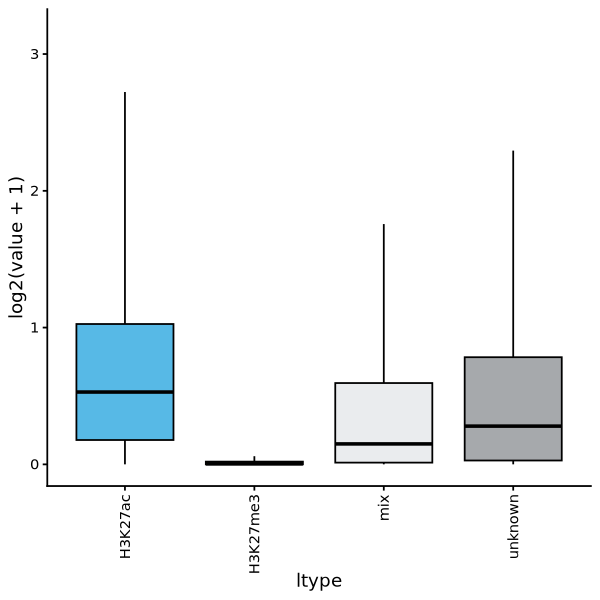

In [637]:
# rrpkm <- rpkm %>% tibble::rownames_to_column("gene") %>% reshape2::melt()

t1 <- merge(glist1, rrpkm, by.x = c("gene", "variable")) %>%
mutate(value = ifelse(value > 8, 8, value)) %>%
ggplot(aes(x = ltype, y = log2(value+1), fill = ltype)) + 
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
theme_classic() +
scale_fill_manual(values = c("#2EA7E0", "#956134", "#E5E7E9", "#909497")) +  
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + NoLegend()

options(repr.plot.width = 5, repr.plot.height = 5)
t1

In [104]:
qdf <- olist4 %>% filter(celltype %in% qorder) %>% 
filter(!(celltype %in% badcelltype)) %>% 
filter(type.x == type.y, type.x == "H3K27me3") %>% 
dplyr::select(chrom1,start1,end1,chrom2,start2,end2, celltype)

qdf$range1 <- paste0(qdf[,1], ":", qdf[,2], "-", qdf[,3])
qdf$range2 <- paste0(qdf[,4], ":", qdf[,5], "-", qdf[,6])

qdf2 <- olist4 %>% filter(celltype %in% qorder) %>% 
filter(!(celltype %in% badcelltype)) %>% 
filter(type.x == type.y, type.x == "H3K27ac") %>% 
dplyr::select(chrom1,start1,end1,chrom2,start2,end2, celltype)

qdf2$range1 <- paste0(qdf2[,1], ":", qdf2[,2], "-", qdf2[,3])
qdf2$range2 <- paste0(qdf2[,4], ":", qdf2[,5], "-", qdf2[,6])

In [106]:
glist1 <- list()
for (f in qorder){
    qqdf <- qdf[qdf$celltype == f,] %>% distinct
    if (nrow(qqdf) > 0){ 
        tmp1 <- qqdf[,1:3] #%>% distinct
        tmp2 <- qqdf[,4:6] #%>% distinct
        ccrange1 <- GenomicRanges::GRanges(tmp1[, 1], IRanges::IRanges(as.integer(tmp1[, 2]), as.integer(tmp1[, 3])))
        ccrange2 <- GenomicRanges::GRanges(tmp2[, 1], IRanges::IRanges(as.integer(tmp2[, 2]), as.integer(tmp2[, 3]))) #, range = qqdf$range2)
        idx <- S4Vectors::queryHits(GenomicRanges::findOverlaps(ccrange1, generange))
        idy <- S4Vectors::queryHits(GenomicRanges::findOverlaps(ccrange2, generange))
        qqdf$l_wg <- qqdf$r_wg <- 0
        qqdf[idx,]$l_wg <- 1
        qqdf[idy,]$r_wg <- 1
        glist1[[f]] <- qqdf
}}

glist1 <- do.call(rbind, glist1)

In [107]:
glist1 %>% mutate(class = as.character(r_wg + l_wg)) %>%
dplyr::select(celltype, class) %>%
table %>% as.data.frame %>%
group_by(celltype) %>% mutate(ratio = Freq/sum(Freq)) %>%
ungroup %>% group_by(class) %>%
summarise(ratio = mean(ratio))

class ratio    
1 0     0.6019509
2 1     0.2838740
3 2     0.1141752

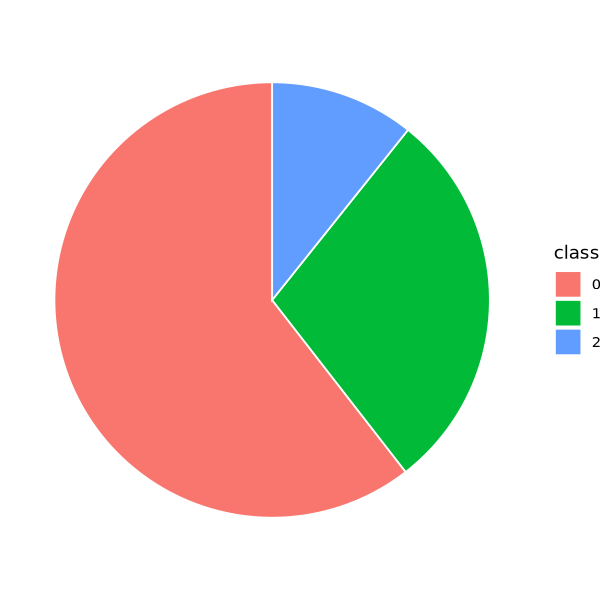

In [341]:
t1 <- glist1 %>% mutate(class = as.character(r_wg + l_wg)) %>%
dplyr::select(celltype, class) %>%
table %>% as.data.frame %>%
group_by(celltype) %>% mutate(ratio = Freq/sum(Freq)) %>%
ungroup %>% group_by(class) %>%
summarise(ratio = mean(ratio)) %>%
ggplot(aes(x = "", y = ratio, fill = class)) + 
geom_bar(stat="identity", width = 1, color = 'white') +
coord_polar("y", start=0) +
theme_void()

options(repr.plot.width = 5, repr.plot.height = 5)
t1

In [108]:
glist2 <- list()
for (f in qorder){
    qqdf <- qdf2[qdf2[,7] == f,] %>% distinct
    if (nrow(qqdf) > 0){
        tmp1 <- qqdf[,1:3] #%>% distinct
        tmp2 <- qqdf[,4:6] #%>% distinct
        ccrange1 <- GenomicRanges::GRanges(tmp1[, 1], IRanges::IRanges(as.integer(tmp1[, 2]), as.integer(tmp1[, 3])))
        ccrange2 <- GenomicRanges::GRanges(tmp2[, 1], IRanges::IRanges(as.integer(tmp2[, 2]), as.integer(tmp2[, 3]))) #, range = qqdf$range2)
        idx <- S4Vectors::queryHits(GenomicRanges::findOverlaps(ccrange1, generange))
        idy <- S4Vectors::queryHits(GenomicRanges::findOverlaps(ccrange2, generange))
        qqdf$l_wg <- qqdf$r_wg <- 0
        qqdf[idx,]$l_wg <- 1
        qqdf[idy,]$r_wg <- 1
        glist2[[f]] <- qqdf
    }
}
    
glist2 <- do.call(rbind, glist2)

In [109]:
glist2 %>% mutate(class = as.character(r_wg + l_wg)) %>%
dplyr::select(celltype, class) %>%
table %>% as.data.frame %>%
group_by(celltype) %>% mutate(ratio = Freq/sum(Freq)) %>%
ungroup %>% group_by(class) %>%
summarise(ratio = mean(ratio))

class ratio    
1 0     0.4119023
2 1     0.4079337
3 2     0.1801640

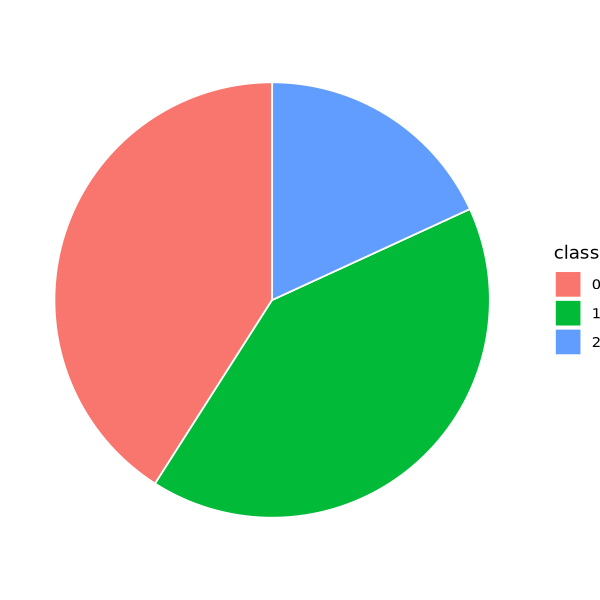

In [343]:
t2 <- glist2 %>% mutate(class = as.character(r_wg + l_wg)) %>%
dplyr::select(celltype, class) %>%
table %>% as.data.frame %>%
group_by(celltype) %>% mutate(ratio = Freq/sum(Freq)) %>%
ungroup %>% group_by(class) %>%
summarise(ratio = mean(ratio)) %>%
ggplot(aes(x = "", y = ratio, fill = class)) + 
geom_bar(stat="identity", width = 1, color = 'white') +
coord_polar("y", start=0) +
theme_void()

options(repr.plot.width = 5, repr.plot.height = 5)
t2

## Plot heatmaps

In [66]:
norder2 <- c('L23IT','L2IT','L34IT','L4IT','L35IT','L45IT','L5IT','L56IT','L6IT-1','L6IT-2','L6CT','L6B','L56NP','URL',
             'SST','PVALB','PV-CHC','VIP','PAX6','SNCG','LAMP5','LAMP5-LHX6','FBL','AST','MGC','OPC','OGC')

In [815]:
norder3 <- olist4 %>% distinct %>% dplyr::select(celltype, ltype) %>% table %>% as.data.frame %>%
group_by(celltype) %>% mutate(ratio = Freq/sum(Freq)) %>% ungroup %>%
filter(ltype == "unknown") %>%
arrange(ratio) %>% dplyr::select(celltype) %>% unlist %>% as.character

norder3 <- setdiff(norder3, badcelltype)

In [755]:
rpkm <- read.table("../04.clustering/02.RNA/MiniAtlas_RNA_merged_dual_filt_clean_250724.subclass.rpkm.txt",
                  row.names = 1, header = T, check.names = F)
acsig <- ac10 %>% tibble::rownames_to_column("peak") %>% reshape2::melt()
mesig <- me10 %>% tibble::rownames_to_column("peak") %>% reshape2::melt()
genesig <- rpkm %>% tibble::rownames_to_column("gene") %>% reshape2::melt()

Using peak as id variables

Using peak as id variables

Using gene as id variables



In [87]:
d1 <- read.table("active_loop.gene.bedpe") 
d2 <- read.table("repressive_loop.gene.bedpe") 

qgene1 <- unique(d1$V14) ### all genes
qloop1 <- d1[,c(1:6,14)] %>% distinct ### all interactions covering tss
qloop2 <- d2[,c(1:6,14)] %>% distinct ### all interactions covering tss

length(qgene1); nrow(qloop1); nrow(qloop2)

[1] 16466

[1] 60969

[1] 2473

In [871]:
### active loops
qdf <- merge(olist4, qloop1, by.x = c("chrom1", "start1", "end1", "chrom2", "start2", "end2"), 
             by.y = c("V1", "V2", "V3", "V4", "V5", "V6")) %>%
mutate(loop = paste0(range1, "_", range2))
qdf1 <- merge(qdf, acsig, by.x = c("range1", "celltype"), by.y = c("peak", "variable"))
qdf1 <- merge(qdf1, acsig, by.x = c("range2", "celltype"), by.y = c("peak", "variable"))
qdf1 <- merge(qdf1, genesig, by.x = c("V14", "celltype"), by.y = c("gene", "variable"))

### repressive loops
qdf <- merge(olist4, qloop2, by.x = c("chrom1", "start1", "end1", "chrom2", "start2", "end2"), 
             by.y = c("V1", "V2", "V3", "V4", "V5", "V6")) %>%
mutate(loop = paste0(range1, "_", range2))
qdf2 <- merge(qdf, mesig, by.x = c("range1", "celltype"), by.y = c("peak", "variable"))
qdf2 <- merge(qdf2, mesig, by.x = c("range2", "celltype"), by.y = c("peak", "variable"))
qdf2 <- merge(qdf2, genesig, by.x = c("V14", "celltype"), by.y = c("gene", "variable"))

### Plot active loops first!
sdf <- qdf1 %>% 
group_by(loop, celltype) %>%
summarise(value = mean(value), ### use mean gene expression per loop as representation
          value.x = unique(value.x), value.y = unique(value.y)) %>%
ungroup 

mtx2 <- sdf %>% 
mutate(sumsig = ((value.x + value.y)/2)) %>%
dplyr::select(sumsig, celltype, loop) %>% distinct %>%
reshape2::dcast(loop ~ celltype, value.var = "sumsig", fun.aggregate = mean) %>%
tibble::column_to_rownames("loop")
mtx2[is.na(mtx2)] <- 0
mtx2 <- mtx2[, setdiff(colnames(mtx2), badcelltype)]

mtx4 <- sdf %>% 
dplyr::select(value, celltype, loop) %>% distinct %>%
reshape2::dcast(loop ~ celltype, value.var = "value", fun.aggregate = mean) %>%
tibble::column_to_rownames("loop")
mtx4[is.na(mtx4)] <- 0
mtx4 <- mtx4[, setdiff(colnames(mtx4), badcelltype)]

`summarise()` has grouped output by 'loop'. You can override using the `.groups` argument.


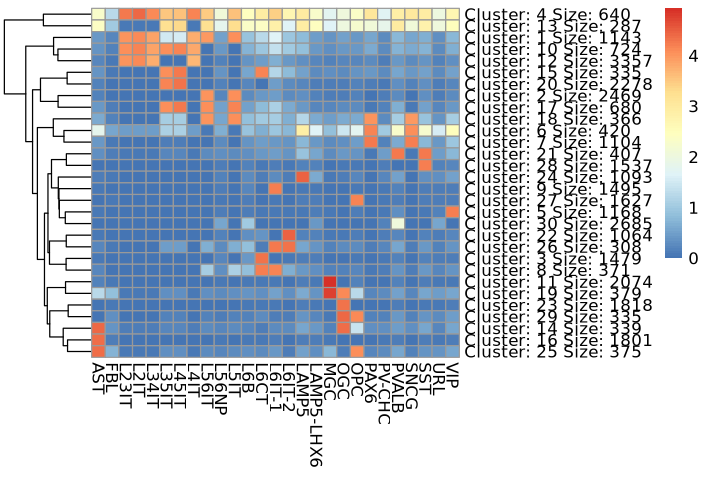

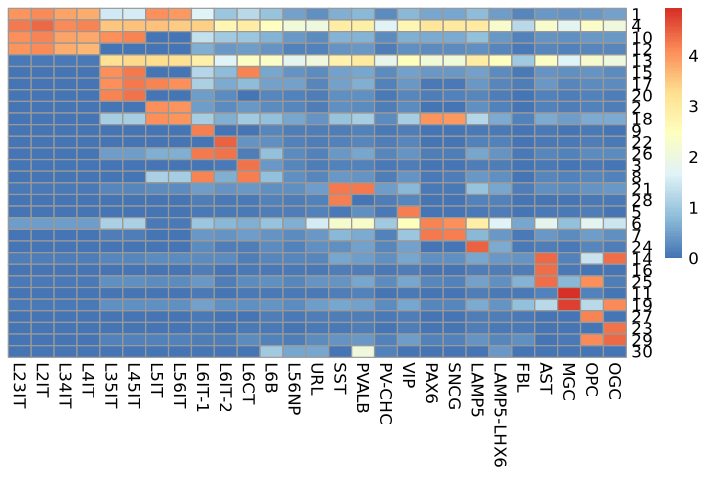

In [854]:
### order heatmap
kn <- 30
set.seed(921)

options(repr.plot.width = 6, repr.plot.height = 4)
df1 <- log2(mtx2 + 1) %>% 
pheatmap(cluster_cols = F, cluster_rows = T, kmeans_k = kn)

smat1 <- df1$kmeans$centers[,intersect(norder2, colnames(mtx2))]
max_indices <- max.col(smat1)
permutation_vector <- order(max_indices)
smat1 <- smat1[permutation_vector, ]
rorder <- smat1 %>% rownames

smat1[rorder,] %>% pheatmap(cluster_cols = F, cluster_rows = F)

qorder <- df1$kmeans$cluster %>% as.data.frame %>%
setNames("kmeansk") %>% 
mutate(kmeansk = factor(kmeansk, levels = rorder)) %>%
arrange(kmeansk)

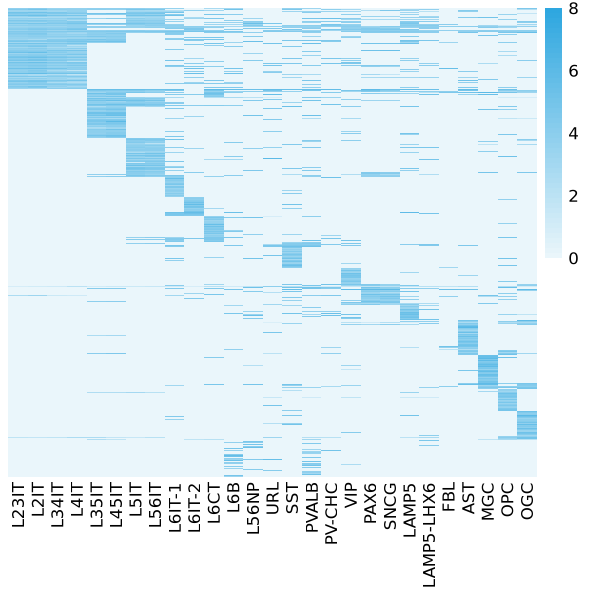

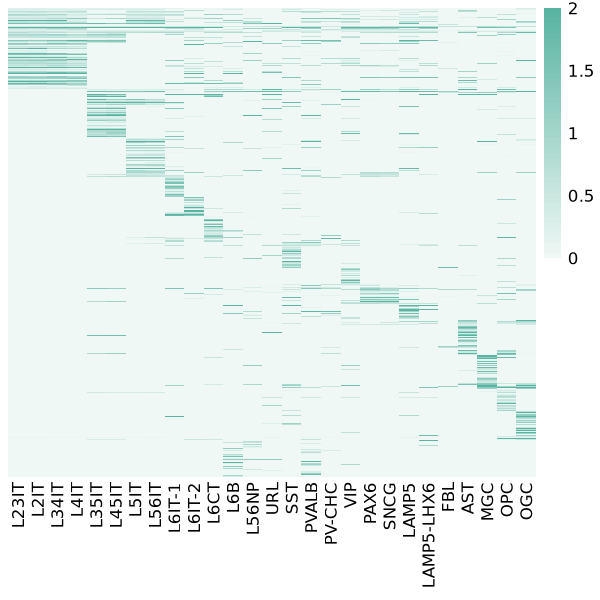

In [872]:
options(repr.plot.width = 5, repr.plot.height = 5)
t1 <- log2(mtx2[rownames(qorder), colnames(smat1)]+1) %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, 
         border_color = NA, show_rownames = F, breaks = seq(0, 8, 0.16),
         color = colorRampPalette(c("#eaf6fb", "#2EA7E0"))(50))

t2 <- log2(mtx4[rownames(qorder), colnames(smat1)]+1) %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90,
         border_color = NA, show_rownames = F, breaks = seq(0, 2, 0.04),
         color = colorRampPalette(c("#eff8f5", "#59b4a2"))(50))

In [875]:
### Plot repressive loops
sdf <- qdf2 %>% 
group_by(loop, celltype) %>%
summarise(value = mean(value), ### use mean gene expression per loop as representation
          value.x = unique(value.x), value.y = unique(value.y)) %>%
ungroup 

mtx2 <- sdf %>% 
mutate(sumsig = ((value.x + value.y)/2)) %>%
dplyr::select(sumsig, celltype, loop) %>% distinct %>%
reshape2::dcast(loop ~ celltype, value.var = "sumsig", fun.aggregate = mean) %>%
tibble::column_to_rownames("loop")
mtx2[is.na(mtx2)] <- 0
mtx2 <- mtx2[, setdiff(colnames(mtx2), badcelltype)]

mtx4 <- sdf %>% 
dplyr::select(value, celltype, loop) %>% distinct %>%
reshape2::dcast(loop ~ celltype, value.var = "value", fun.aggregate = mean) %>%
tibble::column_to_rownames("loop")
mtx4[is.na(mtx4)] <- 0
mtx4 <- mtx4[, setdiff(colnames(mtx4), badcelltype)]

`summarise()` has grouped output by 'loop'. You can override using the `.groups` argument.


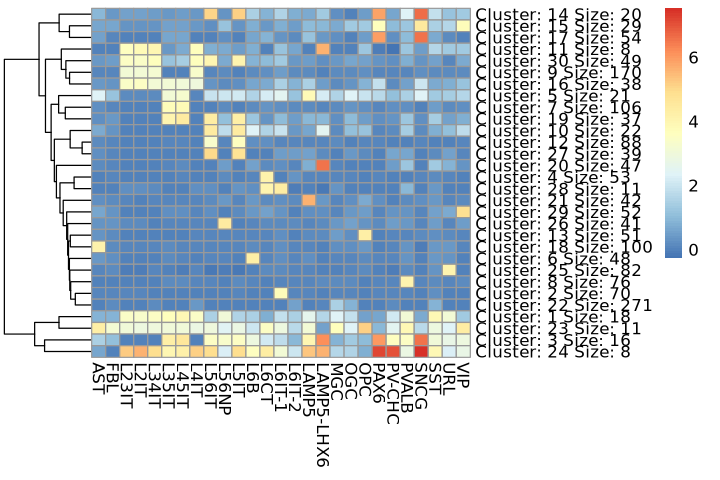

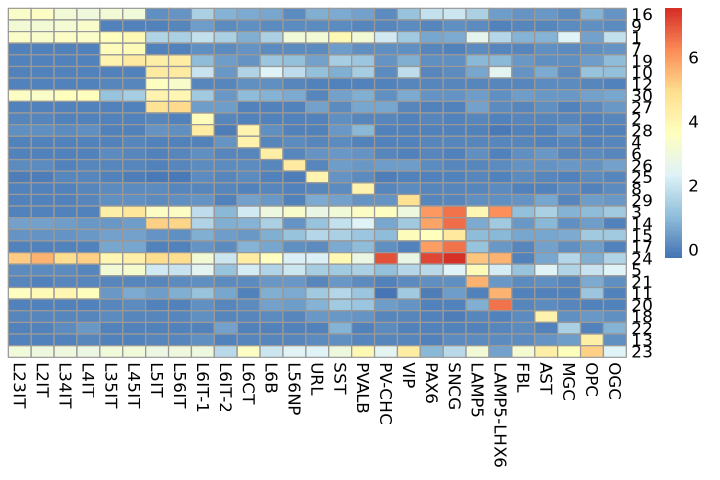

In [880]:
kn <- 30
set.seed(921)

options(repr.plot.width = 6, repr.plot.height = 4)
df1 <- (log2(mtx2 + 1) - log2(mtx4 + 1)) %>%
# log2(mtx2 + 1) %>% 
pheatmap(cluster_cols = F, cluster_rows = T, kmeans_k = kn)

smat1 <- df1$kmeans$centers[,intersect(norder2, colnames(mtx2))]
max_indices <- max.col(smat1)
permutation_vector <- order(max_indices)
smat1 <- smat1[permutation_vector, ]
rorder <- smat1 %>% rownames

smat1[rorder,] %>% pheatmap(cluster_cols = F, cluster_rows = F)

qorder <- df1$kmeans$cluster %>% as.data.frame %>%
setNames("kmeansk") %>% 
mutate(kmeansk = factor(kmeansk, levels = rorder)) %>%
arrange(kmeansk)

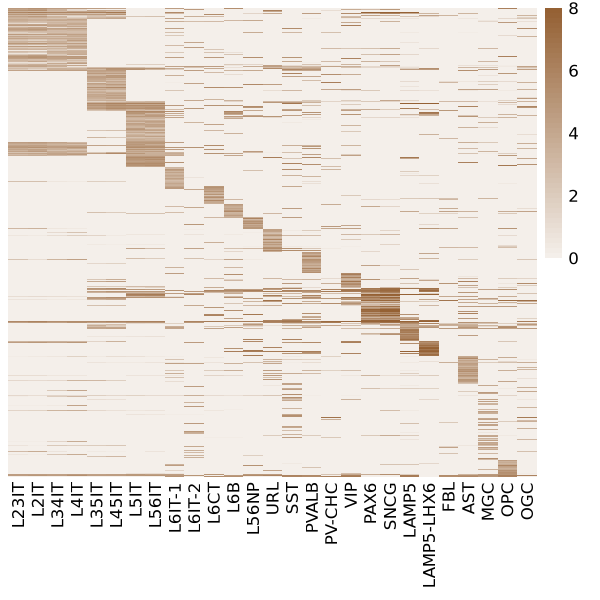

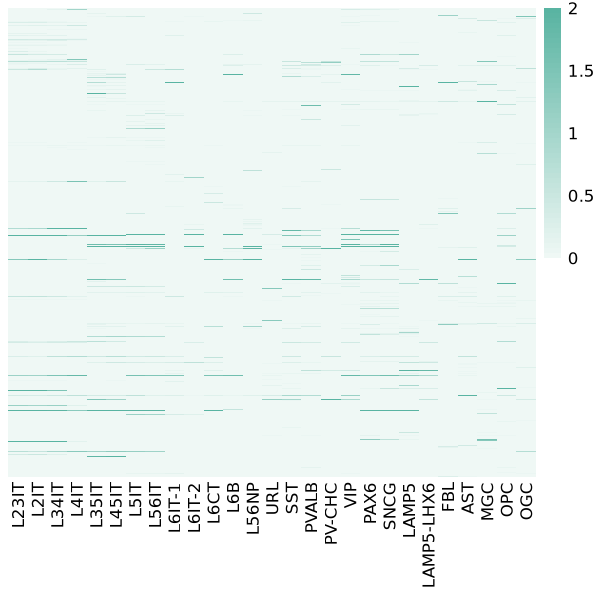

In [881]:
options(repr.plot.width = 5, repr.plot.height = 5)
t1 <- log2(mtx2[rownames(qorder), colnames(smat1)]+1) %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, 
         border_color = NA, show_rownames = F, breaks = seq(0, 8, 0.16),
         color = colorRampPalette(c("#f4efea", "#956134"))(50))

t2 <- log2(mtx4[rownames(qorder), colnames(smat1)]+1) %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90,
         border_color = NA, show_rownames = F, breaks = seq(0, 2, 0.04),
         color = colorRampPalette(c("#eff8f5", "#59b4a2"))(50))

### Does active loops support abc predictions?

In [97]:
abc <- read.table("../08.conns/plot/broad_abc_filtcelltype_conns.txt", header = T)
flist <- list()
for (f in intersect(unique(d1$V7), unique(abc$CellType))){
    ### abc thresholded with 50kb to match loop requirement
    tmp1 <- abc %>% filter(abs(TargetGeneTSS - end) >= 50000) %>%
    filter(CellType == f) %>% dplyr::select(chr, start, end, TargetGeneTSS) %>% distinct %>% 
    dplyr::select(chr, start, end) %>% setNames(c("chrom", "start", "end"))
    tmp2 <- abc %>% filter(abs(TargetGeneTSS - end) >= 50000) %>%
    filter(CellType == f) %>% dplyr::select(chr, start, end, TargetGeneTSS) %>% distinct %>% 
    dplyr::select(chr, TargetGeneTSS) %>% mutate(end = TargetGeneTSS + 1) %>% setNames(c("chrom", "start", "end"))
    lrange1 <- GRanges(tmp1[,1], ranges = IRanges(as.integer(tmp1[,2]), as.integer(tmp1[,3])))
    lrange2 <- GRanges(tmp2[,1], ranges = IRanges(as.integer(tmp2[,2]-500), as.integer(tmp2[,3]+500)))
    gi1 <- GInteractions(lrange1, lrange2)
    i1 <- tmp1 %>% nrow

    ### active loops
    tmp1 <- d1 %>% filter(V7 == f) %>% dplyr::select(V1,V2,V3, V4,V5,V6) %>% distinct %>% 
    dplyr::select(V1,V2,V3) %>% setNames(c("chrom", "start", "end"))
    tmp2 <- d1 %>% filter(V7 == f) %>% dplyr::select(V1,V2,V3, V4,V5,V6) %>% distinct %>% 
    dplyr::select(V4,V5,V6) %>% setNames(c("chrom", "start", "end"))
    lrange1 <- GRanges(tmp1[,1], ranges = IRanges(as.integer(tmp1[,2]), as.integer(tmp1[,3])))
    lrange2 <- GRanges(tmp2[,1], ranges = IRanges(as.integer(tmp2[,2]), as.integer(tmp2[,3])))
    gi2 <- GInteractions(lrange1, lrange2)
    i2 <- tmp2 %>% nrow

    ### repressive loops
    tmp1 <- d2 %>% filter(V7 == f) %>% dplyr::select(V1,V2,V3, V4,V5,V6) %>% distinct %>%
    dplyr::select(V1,V2,V3) %>% setNames(c("chrom", "start", "end"))
    tmp2 <- d2 %>% filter(V7 == f) %>% dplyr::select(V1,V2,V3, V4,V5,V6) %>% distinct %>%
    dplyr::select(V4,V5,V6) %>% setNames(c("chrom", "start", "end"))
    lrange1 <- GRanges(tmp1[,1], ranges = IRanges(as.integer(tmp1[,2]), as.integer(tmp1[,3])))
    lrange2 <- GRanges(tmp2[,1], ranges = IRanges(as.integer(tmp2[,2]), as.integer(tmp2[,3])))
    gi3 <- GInteractions(lrange1, lrange2)
    i3 <- tmp2 %>% nrow

    ### unspecific loops
    tmp1 <- olist4 %>% filter(celltype == f) %>%
    filter(ltype != "H3K27ac") %>% filter(type.x == "H3K27ac" | type.y == "H3K27ac") %>%
    dplyr::select(chrom1,start1,end1) %>% setNames(c("chrom", "start", "end"))
    
    tmp2 <- olist4 %>% filter(celltype == f) %>%
    filter(ltype != "H3K27ac") %>% filter(type.x == "H3K27ac" | type.y == "H3K27ac") %>%
    dplyr::select(chrom2,start2,end2) %>% setNames(c("chrom", "start", "end"))
    
    lrange1 <- GRanges(tmp1[,1], ranges = IRanges(as.integer(tmp1[,2]), as.integer(tmp1[,3])))
    lrange2 <- GRanges(tmp2[,1], ranges = IRanges(as.integer(tmp2[,2]), as.integer(tmp2[,3])))
    gi4 <- GInteractions(lrange1, lrange2)
    i4 <- tmp2 %>% nrow

    qov1 <- queryHits(findOverlaps(gi1, gi2, type = "any")) %>% unique %>% length
    sov1 <- subjectHits(findOverlaps(gi1, gi2, type = "any")) %>% unique %>% length
    qov2 <- queryHits(findOverlaps(gi1, gi3, type = "any")) %>% unique %>% length
    sov2 <- subjectHits(findOverlaps(gi1, gi3, type = "any")) %>% unique %>% length
    qov3 <- queryHits(findOverlaps(gi1, gi4, type = "any")) %>% unique %>% length
    sov3 <- subjectHits(findOverlaps(gi1, gi4, type = "any")) %>% unique %>% length

    flist[[paste0(f)]] <- data.frame(abc = i1, aloops = i2, rloops = i3, mloop = i4,
                                     abc_ovlp_a = qov1, abc_ovlp_r = qov2, abc_ovlp_m = qov3,
                                     a_ovlp_abc = sov1, r_ovlp_abc = sov2, m_ovlp_abc = sov3,
                                     celltype = f)

}

flist <- do.call(rbind, flist)

In [126]:
flist2 <- list()
for (f in rownames(flist)){
    d1 <- flist[flist$celltype == f, "a_ovlp_abc"]
    d2 <- flist[flist$celltype == f, "aloops"]
    d3 <- flist[flist$celltype == f, "m_ovlp_abc"]
    d4 <- flist[flist$celltype == f, "mloop"]
    tr <- fisher.test(matrix(c(d1, d2-d1, d3, d4-d3), ncol = 2))
    flist2[[f]] <- data.frame(celltype = f, or = tr$estimate, p.val = tr$p.value)    
}
flist2 <- do.call(rbind, flist2)
flist2$fdr <- p.adjust(flist2$p.val, method = "BH")

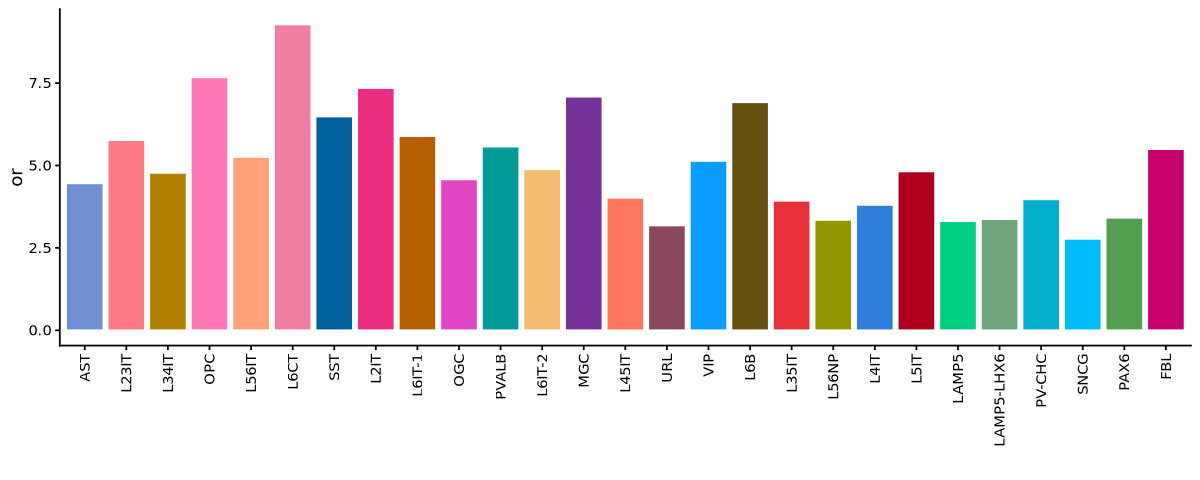

In [134]:
t1 <- flist2 %>%
filter(!(celltype %in% badcelltype)) %>%
mutate(celltype = factor(celltype, levels = qorder)) %>%
ggplot(aes(x = celltype, y = or, fill = celltype)) + 
geom_col(color = "white") + 
theme_classic() + 
xlab("") +
scale_fill_manual(values = ccol2) + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) + 
NoLegend()

t1

## Check pathways enrichment with loops anchor genes

In [ ]:
qtable3 <- read.table("repressive_loop.gene.GOanalysis.tsv", row.names = 1, header = T, sep = "\t")

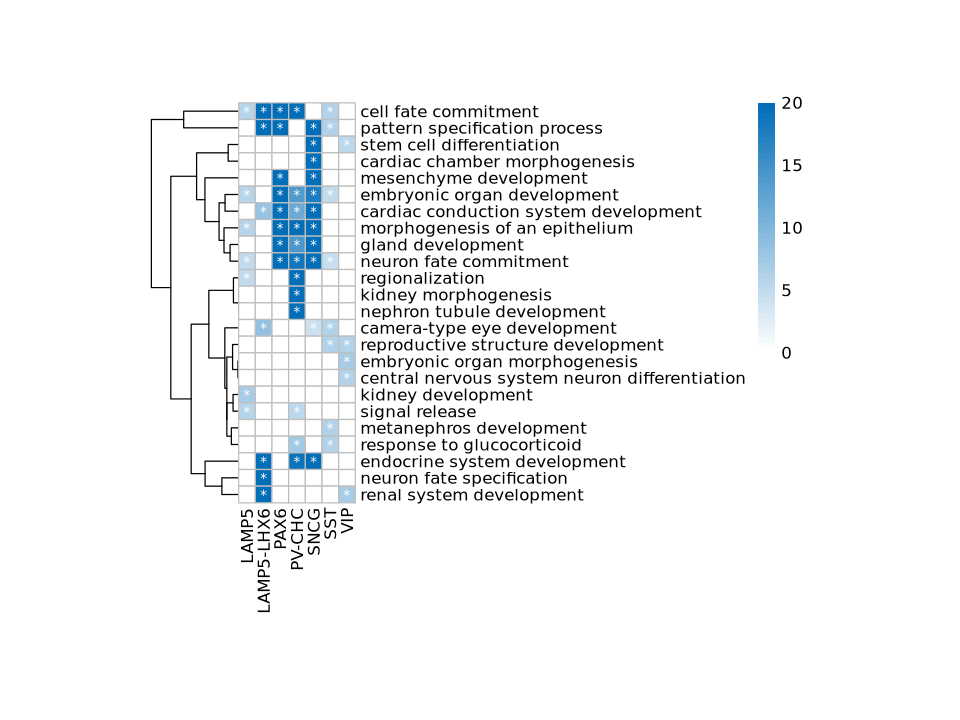

In [24]:
qterm1 <- qtable3 %>%
group_by(celltype) %>% filter(p.adjust < 0.05, Count >= 5, Count <= 500) %>%
slice_max(order_by = -log10(p.adjust), n = 5) %>%
ungroup %>% dplyr::select(Description) %>% unlist %>% unique

tmp <- qtable3 %>%
reshape2::dcast(Description ~ celltype, value.var = "p.adjust", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description")
tmp[is.na(tmp)] <- 1

ttp1 <- -log2(tmp[qterm1, ])
lmat1 <- tmp
lmat1 <- ifelse(lmat1 < 0.05, "*", "")

options(repr.plot.width = 8, repr.plot.height = 6)
t1 <- ttp1 %>% 
pheatmap(cluster_cols = F, cluster_rows = T, 
         border_color = "gray", show_rownames = T,
         angle_col = 90, cellwidth = 10, cellheight = 10, breaks = seq(0, 20, 0.4),
         display_numbers = lmat1[rownames(ttp1), ], number_color = "white",
         color = colorRampPalette(c("white", "#036EB8"))(50))

In [13]:
qtable4 <- read.csv("active_loop.gene.GOanalysis.tsv", row.names = 1, header = T, sep = "\t")

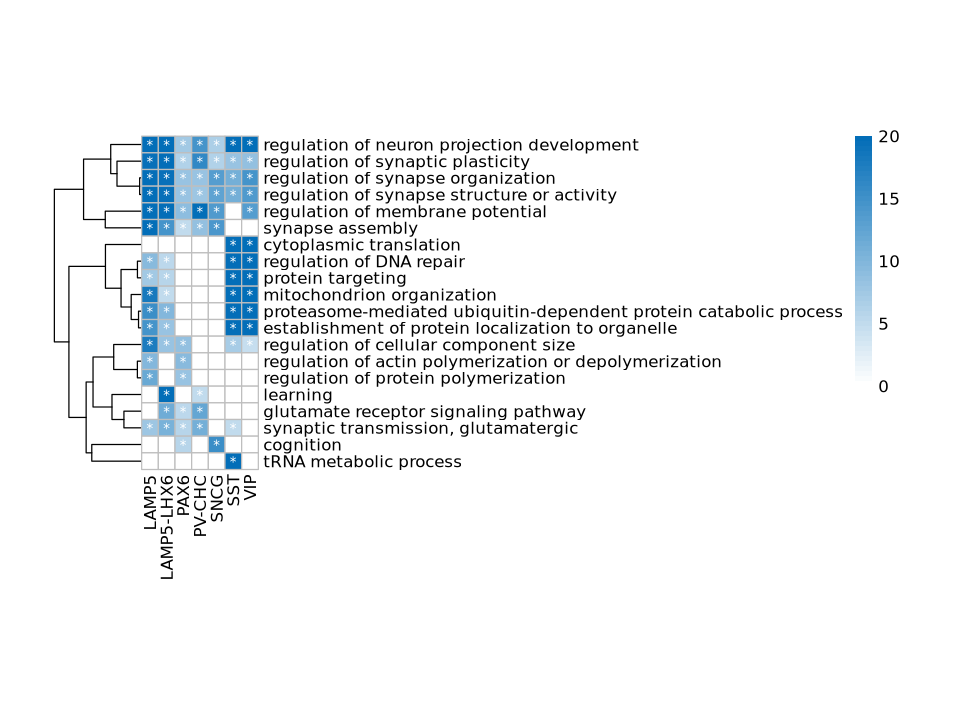

In [25]:
qterm1 <- qtable4 %>% filter(celltype %in% unique(qtable3$celltype)) %>%
group_by(celltype) %>% filter(p.adjust < 0.05, Count >= 5, Count <= 500) %>%
slice_max(order_by = -log10(p.adjust), n = 5) %>%
ungroup %>% dplyr::select(Description) %>% unlist %>% unique

tmp <- qtable4 %>% filter(celltype %in% unique(qtable3$celltype)) %>%
reshape2::dcast(Description ~ celltype, value.var = "p.adjust", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description")
tmp[is.na(tmp)] <- 1

ttp1 <- -log2(tmp[qterm1, ])
ttp1[ttp1 > 20] <- 20

lmat1 <- tmp
lmat1 <- ifelse(lmat1 < 0.05, "*", "")

options(repr.plot.width = 8, repr.plot.height = 6)
t2 <- ttp1 %>% 
pheatmap(cluster_cols = F, cluster_rows = T, 
         border_color = "gray", show_rownames = T,
         angle_col = 90, cellwidth = 10, cellheight = 10, breaks = seq(0, 20, 0.4),
         display_numbers = lmat1[rownames(ttp1), ], number_color = "white",
         color = colorRampPalette(c("white", "#036EB8"))(50))